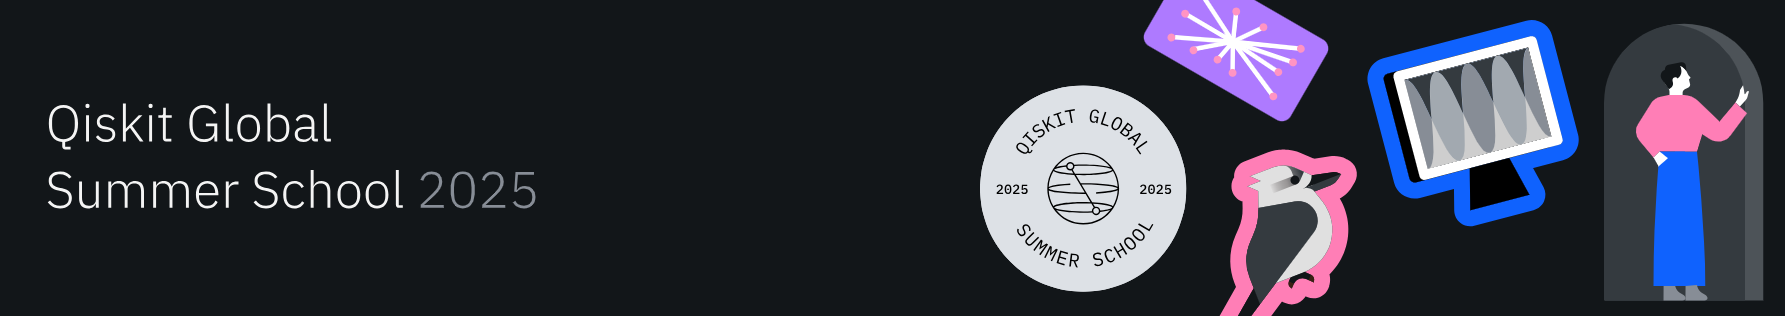



# Lab 3: The Power of 'good sampling' for simulating a chemistry Hamiltonian with SQD

Qiskit Global Summer School 세 번째 코딩 챌린지에 오신 것을 환영합니다. 이번 랩에서는 양자 컴퓨팅의 가장 유망한 응용 분야 중 하나인 양자 화학을 탐구해보도록 하겠습니다. 실제 양자 화학 연구자들이 사용하는 워크플로우를 기반으로 양자컴퓨터에서 분자를 시뮬레이션하는 실제 예제를 소개하며, 각 단계가 목표 달성에 어떤 역할을 하는지 전체 워크플로우를 단계적으로 알아보도록 하겠습니다.

**추천 학습 자료**<br>
이 챌린지를 진행하기 전에 잠깐 시간을 내서, IBM Quantum Learning에서 제공하는 [Variational Algorithm Design](https://quantum.cloud.ibm.com/learning/en/courses/variational-algorithm-design) 코스와 최근에 공개된 코스 중 하나인 [Quantum Diagonalization Algorithms](https://quantum.cloud.ibm.com/learning/en/courses/quantum-diagonalization-algorithms/skqd) 코스를 훑어보고 오시길 추천드립니다.


# 목차

* [Part 1: 개요](#part-1-introduction)
    * 1.1 목표
    * 1.2 원자란 무엇인가?
    * 1.3 슈뢰딩거 방정식
    * 1.4 기저 집합 근사법 - 효율적인 구현법
    * 1.5 해밀토니안
    * [연습문제 1](#exercise1): $O_2$ 분자의 해밀토니안 크기 측정하기
* [Part 2: 변분 양자 고유상태 계산기](#part-2-variational-quantum-eigensolver)
    * VQE – 고전 컴퓨터와 양자 컴퓨터의 협력
* [Part 3: 샘플 기반 양자 대각화(SQD)란 무엇인가?](#part-3-what-is-sample-based-quantum-diagonalization-(SQD)?)
    * SQD 접근법: 양질의 샘플을 이용한 해밀토니안 재구성
    * 관련성 있는 전자 배치의 선택 방법
    * 전자 배치 복원을 통한 노이즈 영항 처리 방법
* [Part 4: SQD를 이용한 $N_2$ 분자의 시뮬레이션](#part-4-how-to-simulate-a-$N_2$-molecule-with-SQD)
    * [연습문제 2](#exercise2): 전자 배치 복원을 통한 비트 교정
* [Part 5: 가설해 개선](#part-5-improve-the-ansatz)
    * [연습문제 3](#exercise3): 기저 집합 변경
    * [연습문제 4](#exercise4): 최적의 큐비트 배치 선택
    * [연습문제 5](#exercise5): LUCJ 가설해에 추가적인 상호작용 도입
* [보너스: 실제 하드웨어에서 실행 및 오류 완화](Bonus-real-hardware-execution-with-error-mitigation )


## 요구사항

본 튜토리얼을 시작하기 전에, 다음의 패키지들이 설치되어 있는지 확인해 주세요.

* Qiskit SDK 2.0 or later with visualization support (`pip install 'qiskit[visualization]'`)
* Qiskit Runtime 0.40 or later (`pip install qiskit-ibm-runtime`)
* Qiskit Addons SQD 0.11.0 or later (`pip install qiskit-addon-sqd`)
* ffsim (`pip install ffsim`)


<div class="alert alert-block alert-warning">
    
⚠️ **참고:** 이번 랩을 진행하기 위해서는 아래 패키지들이 설치되어 있어야 합니다. 이 중 일부는 Windows 운영체제에서는 사용 할 수 없습니다. 만약 Windows를 사용하고 계신다면 [온라인 실습 환경](https://quantum.cloud.ibm.com/docs/en/guides/online-lab-environments#online-lab-environments)을 사용하시기를 추천드립니다.
</div>

In [1]:
%pip install "qc-grader[qiskit,jupyter] @ git+https://github.com/qiskit-community/Quantum-Challenge-Grader.git"
%pip install pyscf
%pip install ffsim
%pip install qiskit_addon_sqd

  Cloning https://github.com/qiskit-community/Quantum-Challenge-Grader.git to /tmp/pip-install-gecvko8z/qc-grader_d01f0393f63149c6ae75821420c95710
  Running command git clone --filter=blob:none --quiet https://github.com/qiskit-community/Quantum-Challenge-Grader.git /tmp/pip-install-gecvko8z/qc-grader_d01f0393f63149c6ae75821420c95710
  Resolved https://github.com/qiskit-community/Quantum-Challenge-Grader.git to commit 1d7a6915623b0cfeac4c114391c279e9d98eb7f9
  Preparing metadata (setup.py) ... done
  Attempting uninstall: webcolors
    Found existing installation: webcolors 1.13
    Not uninstalling webcolors at /opt/conda/lib/python3.11/site-packages, outside environment /opt/.qbraid/environments/qgss_000000/pyenv
    Can't uninstall 'webcolors'. No files were found to uninstall.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you 

In [1]:
import qiskit
import qc_grader
print(f"Qiskit version: {qiskit.__version__}")
print(f"Grader version: {qc_grader.__version__}")

Qiskit version: 2.1.1
Grader version: 0.22.12


Qiskit 버전 `>=2.0.0` 그레이더 버전 `>=0.22.12` 이상이 설치되어 있어야 합니다. 만약 버전이 다르게 표시된다면 커널을 재시작해보시고, 그래도 안 된다면 그레이더를 다시 설치해야 할 수 있습니다.
랩 0에 따라 환경설정을 완료했는지, IBM Quantum 계정이 잘 저장되어 있는지 아래의 셀을 실행해 확인해주세요.

In [2]:
# 계정이 잘 저장되어 있는지 확인합니다
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(name="dmridmrir")
service.saved_accounts()

qiskit_runtime_service._resolve_cloud_instances:WARNING:2025-07-21 08:12:22,620: Default instance not set. Searching all available instances.


{'dmridmrir': {'channel': 'ibm_quantum_platform',
  'url': 'https://cloud.ibm.com',
  'token': 'l6qr396xmea9vBFA1dnrP0oLtypzXeUDBtJbGsqh2yXt',
  'verify': True,
  'private_endpoint': False},
 'qgss-2025': {'channel': 'ibm_quantum_platform',
  'url': 'https://cloud.ibm.com',
  'token': 'Dl2VOYTYQOpgsJhPLVAFK2l1cD3ZsUa08p6Wa5VhK2Z3',
  'instance': 'crn:v1:bluemix:public:quantum-computing:us-east:a/01f45c7c4c944a6cb2d1a70d952bf851:1fca49e0-4496-4936-ac0b-120fdb0c89bf::',
  'verify': True,
  'private_endpoint': False},
 '서정근': {'channel': 'ibm_quantum',
  'url': 'https://auth.quantum.ibm.com/api',
  'token': 'tE9MpigmJ1BTXJPhEVaXX-L8_FZyVJY-jH2KxiW7Qsxj',
  'verify': True,
  'private_endpoint': False}}

# 불러오기

In [3]:
# 공통적으로 사용하는 패키지들을 먼저 불러오기
import numpy as np
from math import comb
import warnings
import pyscf
import matplotlib.pyplot as plt
import pickle
from functools import partial

# qiskit 클래스들을 불러오기
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_gate_map
from qiskit_addon_sqd.fermion import SCIResult, diagonalize_fermionic_hamiltonian, solve_sci_batch

# qiskit ecosystem 패키지들을 불러오기
import ffsim
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit_ibm_runtime import SamplerOptions

# grader 불러오기
from qc_grader.challenges.qgss_2025 import (
    grade_lab3_ex1, 
    grade_lab3_ex2, 
    grade_lab3_ex3,
    grade_lab3_ex4,
    grade_lab3_ex5
)

# 1. 개요

## 1.1 목표

이번 랩의 목표는 양자화학 계산의 기본 개념과 일반적인 워크플로우를 학습하는 것입니다. 또한, 이 과정에서 양자-고전 하이브리드 알고리즘 중 하나인 샘플 기반 양자 대각화 알고리즘 (Sample-based Quantum Diagonalization, SQD)에 대해 배우게 됩니다. SQD는 양자 프로세서(QPU)에서 양자회로를 실행하여 얻은 샘플들을 기반으로 고전적인 대각화 연산을 수행하는 기술입니다. 이 알고리즘은 양자 시스템의 해밀토니안과 같은 양자 연산자의 고윳값을 찾는 데 매우 유용하며, 양자 컴퓨팅과 분산 고전 컴퓨팅 테크닉을 함께 활용하는 방식입니다.

## 1.2 원자란 무엇인가?
여러분 주변의 모든 것은 원자로 이루어져 있습니다. 원자는 물질을 구성하는 아주 작은 기본 단위입니다. "원자(atom)"라는 말은 그리스어로 "더 이상 나눌 수 없다"라는 뜻에서 나왔습니다. 오래전 데모크리토스라는 사람은 세상의 모든 것이 더 이상 쪼갤 수 없는 아주 작은 입자인 "원자"로 이루어져 있다고 생각했습니다.

1913년, 닐스 보어는 전자가 원자 중심 주변을 마치 태양 주위를 도는 행성처럼 원형 궤도를 따라 움직인다고 말했습니다.
하지만 1926년, 에르빈 슈뢰딩거는 전자가 실제로는 완벽한 경로를 따라 움직이는 것이 아니라, 전자가 발견될 가능성이 가장 높은 "구름" 형태의 영역 안에서 윙윙거리며 움직인다고 설명했습니다.


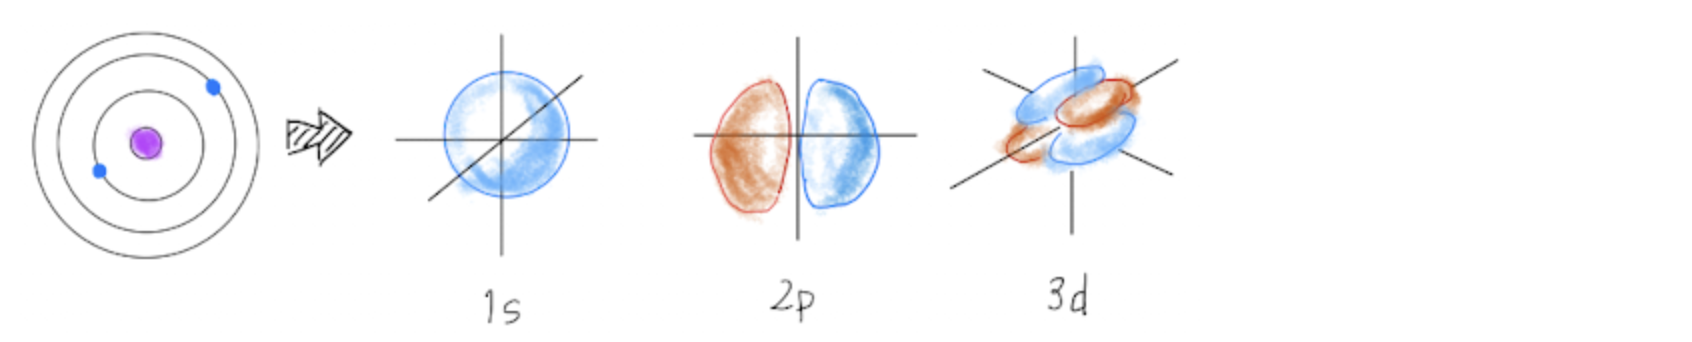

Fig 1. 보어의 원자 모형(왼쪽)과 전자의 양자역학적 및 파동적 특성에 기초한 슈뢰딩거의 원자 모형(오른쪽)의 스케치.　 <br>

이러한 구름(오비탈)은 각기 다른 모양과 에너지 준위를 가지고 있습니다. 전자들은 일반적으로 가장 낮은 에너지 준위(바닥 상태)에 머물러 있지만, 에너지를 받으면 더 높은 에너지 준위로 올라갈 수 있습니다. 다시 원래 상태로 떨어질 때는 그만큼의 에너지를 방출하게 됩니다.

## 1.3 슈뢰딩거 방정식

에르빈 슈뢰딩거는 양자역학 분야에 단순히 새로운 전자 모형을 소개하는 것을 넘어, 유명한 슈뢰딩거 방정식을 만들었습니다. 시간 독립 슈뢰딩거 방정식은 다음과 같습니다:
$$
\hat{H}|\psi\rangle = {E}|\psi\rangle
$$

**$\hat{H}$**  : 해밀토니안 연산자 <br>
**$|\psi\rangle$** : 파동함수 (계의 상태) <br>
**${E}$** : 측정된 에너지 (고윳값) <br>

**양자화학의 목표는 슈뢰딩거 방정식을 풀어서 파동함수를 얻는 것입니다.** 슈뢰딩거 방정식을 만족하는 파동함수를 알게 되면 양자계의 에너지, 운동량, 스핀, 자화 등 다양한 흥미로운 특성들을 알아낼 수 있습니다.

양자화학에서는 흔히 **바닥상태 에너지(ground state energy)** 를 찾는 데 관심을 둡니다. 이는 분자의 바닥상태 에너지를 알면 다음과 같은 많은 정보를 얻을 수 있기 때문입니다.

- 분자가 안정된 형태로 취할 가능성이 높은 모양("평형 상태"라 부름)
- 화학 반응 중 분자들이 어떻게 변화하거나 반응할 수 있는지
- 약물이 체내의 단백질과 결합하는 방식 (Docking 시뮬레이션 등에서 활용)

간단히 말해, 바닥 상태를 찾는 것은 분자가 할 수 있는 모든 흥미로운 행동이 시작되는 시작점을 찾는 것과 같습니다.

하지만 큰 분자들의 경우, 전자의 공간적 분포를 설명하는 파동함수가 매우 복잡하여 **슈뢰딩거 방정식을 정확히 푸는 것이 매우 어렵습니다.** 그래서 완벽히 푸는 대신에, 과학자들은 충분히 근접한 좋은 추정이나 근사를 사용합니다.

## 1.4 기저 집합 근사법 - 효율적인 구현법
양자화학에서 중요한 근사법 중 하나는 **기저 집합(basis set)** 접근법입니다. 기저함수는 **원자나 분자 내 전자의 오비탈(파동함수)을 근사하기 위해 사용되는 수학적 함수들의 집합입니다.** 대부분의 계에 대해 슈뢰딩거 방정식을 정확하게 풀 수 없으므로, 기저 집합을 이용하여 문제를 계산할 수 있도록 만듭니다. 연속적인 원자 오비탈을 완벽히 다루는 대신, 미리 정의된 수학적 함수들(주로 가우시안형 또는 슬레이터형 오비탈)을 사용하여 근사합니다.

이 방법은 선형 결합 원자 오비탈(LCAO: Linear Combination of Atomic Orbitals)로 알려져 있습니다. 이 아이디어는 간단한데 마치 간단하고 알려진 도형들을 더해 복잡한 형태를 만드는 것과 같이 기저 함수들을 결합하여 분자 오비탈을 만듭니다.
- 작은 기저 집합(적은 수의 함수)는 빠르지만 거친 근사치를 제공합니다.
- 큰 기저 집합은 정확도를 향상하지만 계산 비용이 매우 커집니다.

<div class="alert alert-block alert-info"> 
<b>기저함수의 종류</b><br>

- **슬레이터형 오비탈(STOs)**: 실제 원자 오비탈과 매우 비슷한 형태의 수학적 함수입니다. 이는 핵으로부터 멀어질수록 전자 밀도가 감소하는 것을 잘 나타냅니다.
- **가우시안형 오비탈(GTOs)**: 실제 오비탈과 형태적으로는 덜 비슷하지만 계산이 더 용이하여 실제 실습에서 자주 사용됩니다.</div>

슬레이터형 오비탈(STO)은 여러 개의 가우시안형 오비탈(GTO)을 결합하여 근사할 수 있습니다. 즉, 폭이 서로 다른 여러 개의 가우시안을 결함하여 STO의 형태를 모방합니다. 이런 결합을 **축약된 가우시안 함수(contracted Gaussian function)** 라고 부릅니다. 이 아이디어는 최소 기저 집합(minimal basis set) 및 분리 원자가 기저 집합(split-valence basis set)과 같은 다양한 종류의 기저함수의 기반이 됩니다.

- **최소 기저 집합(Minimal Basis Set)**: 오비탈 당 한 개의 함수만을 사용하는 기저 집합입니다. (예: 1s에 한 개의 함수, 2s에 한개의 함수 등).
STO-3G의 경우 각 STO가 3개의 가우시안으로 근사됩니다.
- **분리 원자가 기저 집합(Split-Valence Basis Set)**: 최소 기저집합보다 더 유연하며 정확한 표현을 제공합니다. 원자가 오비탈(결합에 참여하는 최외각 오비탈)을 두 개 이상의 부분으로 나누고 각각 다른 가우시안 조합으로 근사합니다(예: 6-31G). 
이는 화학 결합과 반응의 정확도를 높여줍니다.

### 자주 사용되는 기저 집합들

|   기저 집합    | 설명	| 사용 예시 |  계산 비용  |
| ----------------- | ----------- | ----------- | ----------- |
| **STO-3G**	| 3 개의 가우시안("3G")로 1 개의 STO를 근사한다. 흔히 최소 기저 집합으로 불린다.| 소형 분자에 대한 빠르고 대략적인 초기계산|  낮음  |
| **6-31G**	  | 각 핵심 오비탈마다 6개의 가우시안("6")로 1 STO를 근사한다. 각 원자가 오비탈에는 3 개의 가우시안으로 수축된 함수("3")와 1개의 비수축 가우스 함수("1")로 사용된다.	| 속도와 정확성의 우수한 균형|  중간  |
| **cc-pVDZ**	| 전자 상관 계산을 개선하기 위해 설계된 기저. 각 원자가 오비탈에 1 개 대신 2개의 기저 함수를 두고 분극 함수를 추가한다.	| 상관 효과가 큰 시스템 시뮬레이션에서 높은 정확도 제공 (STO-3G와 6-31G보다 정밀하나 더 비용 집약적)|  높음  |

> 참고: 위 표에서 말하는 계산 비용은 분자 적분을 수행할 때 드는 고전적 계산 지원을 가리킵니다. 기저 함수의 수가 많아질수록 결과의 정확도는 높아지지만, 계산에 소요되는 시간도 그만큼 길어집니다.

요약하자면, 분자 시스템에 대해 슈뢰딩거 방정식을 정확히 푸는 일은 거의 불가능하므로, 이미 알려진 함수들을 결합해 유연한 근사 파동함수를 구성한 뒤, 그 파동함수를 조정하여 시스템의 에너지를 최소화합니다.

### 예시: $N_2$ 해밀토니안의 사이즈 계산
비교적 작은 분자인 질소($N_2$)라도 시뮬레이션의 목표 정확도에 따라 해밀토니안 행렬 $H$의 차원이 얼마나 커질 수 있는지 살펴보기 위해 이 예시를 제시합니다. 아래에서는 계산에 사용할 $N_2$의 공간 오비탈 수, 스핀 오비탈 수, 그리고 전자 수를 임의로 설정하였습니다.

아래 표에 제시된 공간 오비탈 수와 전자 수를 이용하여 전자들이 공간 오비탈에 배치될 수 있는 경우의 수 (스핀 배치)를 계산하면, 이는 $N_2$ 분자 해밀토니안의 행렬 크기를 가늠하는 지표가 됩니다.


|   |    STO-3G  |  6-31G  | cc-pVDZ  |  
|:-------|:------:|:-------:|:-------:|
|공간 오비탈 수 | (10) **8**| (18) **16** | (28) **26** |
|스핀 오비탈 수 | (20) **16**| (36) **32**| (56) **52** |
| α-스핀 전자 수  | (7) **5**| (7) **5**| (7) **5** |
| β-스핀 전자 수  | (7) **5**| (7) **5**| (7) **5** |


<p style="text-align:center;">Table 1: $N_2$ 분자에 대해 선택한 기저집합별 오비탈 및 전자 수</p>

- (#) : 본 예시에서 설정한 오비탈 및 전자 수
- **#** : 핵심 오비탈 (*1s*)를 고정한 뒤 전자 수와 공간 오비탈 수를 각각 2개씩 줄였을 때의 값

<div class="alert alert-block alert-warning">
    
⚠️ **참고:** 이 예시에서는 $1s$ 핵심 오비탈을 화학적으로 비활성으로 간주합니다. 따라서 핵심 오비탈을 고정하여 전자 2개와 공간 오비탈 2개, 즉 스핀 궤조 4개(큐비트 4개)를 절약할 수 있습니다. 이 방법은 실제 화학 시뮬레이션에서 자주 사용되는 유용한 근사 기법중 하나입니다. 이 기법을 적용할 떄는 **굵게 표기된** 수치를 사용하여 $N_2$ 해밀토니안의 모든 가능한 전자 배치를 계산해주세요.
</div>

보시다시피, 가능한 모든 스핀 배치를 결정하는 문제는 본질적으로 조합(combination)의 문제입니다. 이제 주어진 오비탈에 대해 **$\alpha$-스핀 (스핀 업)** 전자와 **$\beta$-스핀 (스핀 다운)** 전자가 각각 얼마나 다양한 방식으로 채워질 수 있는지 수학적으로 계산해 보겠습니다. 전체 가능한 스핀 배치의 수는 두 가지를 곱하여 얻을 수 있습니다.

<p style="text-align:center;">전체 전자 배치의 수 = (전체 α-스핀 배치의 수) × (전체 β-스핀 배치의 수)</p>

$$ \Large{n}\Large{C}n_α \times n\Large{C}n_β = \Large\frac{n!}{n_α!(n-n_α)!} \times \Large\frac{n!}{n_β!(n-n_β)!}  $$

여기서
**$n$**: 공간 오비탈의 개수,
**$n_α$**: α-스핀 전자의 개수,
**$n_β$**: β-스핀 전자의 개수

이제 전체 가능한 스핀 배치의 수를 구하는 방법을 알게 되었습니다. 각 기저 집합에 대해 이 값을 직접 계산한 뒤, 그 결과를 그래프로 나타내어 해밀토니안의 행렬 크기가 계산 정확도가 증가함에 따라 어떻게 커지는지를 살펴보겠습니다.

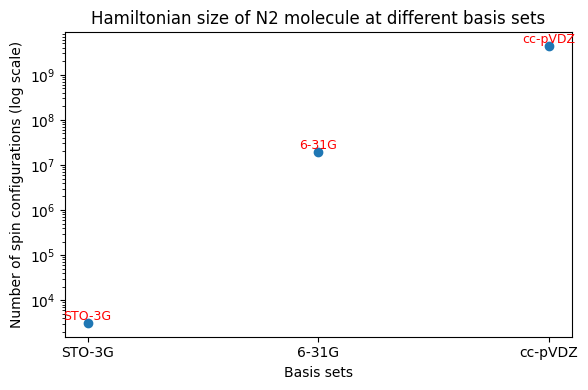

In [4]:
# 가능한 스핀 배치의 수 계산
# 예시: N2 분자에 대한 STO-3G, 6-31G, cc-pVDZ 기저 집합 사용
# 전자 14개, 스핀 오비탈 20개 (공간 오비탈 10개 × 2)

# 각 기저 집합에서의 전체 가능한 전자 배치 수 계산
y1 = comb(8, 5) * comb(8, 5)       # STO-3G
y2 = comb(16, 5) * comb(16, 5)     # 6-31G
y3 = comb(26, 5) * comb(26, 5)     # cc-pVDZ

# 데이터 정의
y = [y1, y2, y3]
x = list(range(len(y)))
labels = ['STO-3G', '6-31G', 'cc-pVDZ']

# 그래프 그리기 (y축은 로그 스케일로 표현)
plt.figure(figsize=(6, 4))
plt.plot(x, y, 'o')

plt.yscale('log')
plt.xticks(x, labels)
plt.xlabel('Basis sets')
plt.ylabel('Number of spin configurations (log scale)')
plt.title('Hamiltonian size of N2 molecule at different basis sets')

# 각 점 위에 레이블 추가
for i in range(len(x)):
    plt.text(x[i], y[i], f'{labels[i]}', fontsize=9, ha='center', va='bottom', color='red')

plt.tight_layout()
plt.show()

위 그래프에서 Y축은 로그 눈금으로 표현된 점을 참고해주세요. 그래프를 통해, 더 정밀한 근사를 위해 기저 집합의 크기를 증가시키면 가능한 스핀 배치의 수가 기하급수적으로 증가함을 확인할 수 있습니다.

## 연습문제 1: $O_2$ 분자의 해밀토니안 크기 측정하기

이번에는 산소 분자($O_2$)의 해밀토니안 크기를 `6-31G` 기저 집합을 사용하여 계산해 보겠습니다. 산소 분자는 앞서 다룬 질소 분자($N_2$)의 동일한 수의 오비탈을 가지지만 **$\alpha$-스핀 (스핀 업)** 전자가 2개 더 많습니다. 이 연습문제에서 계산에 사용할 숫자들은 아래의 표에 제공되어 있습니다.

<a id="exercise_1"></a>
<div class="alert alert-block alert-success">
    
<b>연습문제 1: $O_2$ 분자의 해밀토니안 크기 측정하기</b> 

아래 표에 제시된 공간 오비탈과 전자의 수를 이용하여, 산소 분자($O_2$)가 `6-31G`기저 집합에 있을 때 가능한 총 전자 스핀 배치의 수를 계산하시오. **직접 코드를 작성하거나 수작업으로 계산하여 답을 구해도 됩니다.**


|   |    STO-3G  |  6-31G  | cc-pVDZ  |  
|:-------|:------:|:-------:|:-------:|
|공간 오비탈 수 | (10) **8**| (18) **16** | (28) **26** |
|스핀 오비탈 수 | (20) **16**| (36) **32**| (56) **52** |
| α-스핀 전자 수  | (9) **7**| (9) **7**| (9) **7** |
| β-스핀 전자 수  | (7) **5**| (7) **5**| () **5** |


<p style="text-align:center;">Table 1: $O_2$ 분자의 각 기저 집합별 오비탈과 전자의 수</p>

- (#) : 각 기저 집합에서 실제 원자 구조를 바탕으로 한 오비탈 혹은 전자의 수
- **#** : 핵심 오비탈(*1s*)을 고정하고 전자 및 공간 오비탈의 수를 각각 2개씩 줄인 경우
</div>


<div class="alert alert-block alert-warning">
    
⚠️ **주의:** 앞서 본 예시에서와 같이, 이 연습문제에서도 핵심 오비탈($1s$ 오비탈) 은 화학적으로 비활성이라고 가정하겠습니다. 이는 핵심 오비탈을 고정하여 전재 2개와 공간 오비탈 2개(즉, 스핀 오비탈 4개 -> 큐비트 4개)를 절약할 수 있음을 의미합니다. 실제 양자화학 시뮬레이션에서 자주 사용되는 유용한 근사법이며 이 근사법을 적용할 때는 위 표에서 **굵게** 표시된 숫자들을 사용하여 $O_2$ 분자의 해밀토니안에 대한 전체 가능한 전자 배치 수를 계산해 주세요.

</div>

In [5]:
# 연습문제 1: 가능한 스핀 배치 수 계산
# 예시: O2 분자에 대한 6-31G 기저 사용
# 전자 16개, 스핀 오비탈 20개 (공간 오비탈 10개 × 2)

# 가능한 전체 전자 배치 수를 계산합니다.
# 힌트: 조합론적(combinatorial) 문제입니다. 수작업으로 계산하거나, 아래의 math.comb() 함수를 사용하여 계산할 수 있습니다.

# --- 아래에 코드를 작성해주세요 ---
### 코드를 작성하여 전체 가능한 스핀 배치의 수를 계산해보세요

α_config = comb(16,7)
β_config = comb(16,5)
total_config = (α_config)*(β_config)
# --- 코드 작성이 완료되었습니다 ---

print(f"Total physical configurations for O2 in the given basis : {α_config:} x {β_config:} = {total_config}")

Total physical configurations for O2 in the given basis : 11440 x 4368 = 49969920


In [6]:
# total_config =  # 수작업으로 계산한 경우 이곳에 정답을 입력하세요. 답안을 제출하기 전에 이 부분의 주석 처리를 해제하세요.

In [6]:
# 아래의 함수를 실행해 답안을 제출해주세요

grade_lab3_ex1(total_config) # Expected result type: integer

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


6-31G 기저 세트로 계산한 답안을 제출한 후에는, 동일한 방식으로 다른 기저 세트(STO-3G 및 cc-pVDZ)에 대해서도 계산하여 결과를 서로 비교해 보십시오. 필요에 따라 계산한 결과를 그래프로 나타내면, 기저 세트의 크기가 증가할수록 가능한 스핀 배치의 수, 즉 해밀토니안 행렬의 크기가 어떻게 증가하는지 한눈에 확인할 수 있습니다.

# 2. 변분 양자 고유상태 계산기(Variational Quantum Eigensolver)

지금까지 슈뢰딩거 방정식, 기저 세트, 그리고 실제 물리적 시스템을 더 정확하기 시뮬레이션하려고 할수록 해밀토니안의 크기가 기하급수적으로 증가한다는 점을 학습했습니다. 이제부터는 이를 효율적으로 해결하기 위한 알고리즘에 대해 살펴보겠습니다.

현재의 잡음이 있는 중간 규모 양자컴퓨터(near-term quantum computer)를 활용하여 계산 화학을 연구하는 연구자들에게 잘 알려진 알고리즘 중 하나는 바로 **변분 양자 고유상태 계산기(Variational Quantum Eigensolver, VQE)** 입니다.

VQE는 변분 원리에 따라 정의된 비용함수 형태의 해밀토니안을 최적화하는 하이브리드 양자-고전 알고리즘입니다. 이번 실습의 주된 목표는 VQE와는 다른 형태의 하이브리드 양자-고전 알고리즘인 샘플 기반 양자 대각화(Sample-based Quantum Diagonalizatoin, SQD)를 학습하는 것이지만, SQD의 주요 구성요소 가운데 많은 부분이 VQE의 핵심 구성요소를 포함하고 있으므로, 이들을 간략히 알아보는 것이 유용할 것입니다.

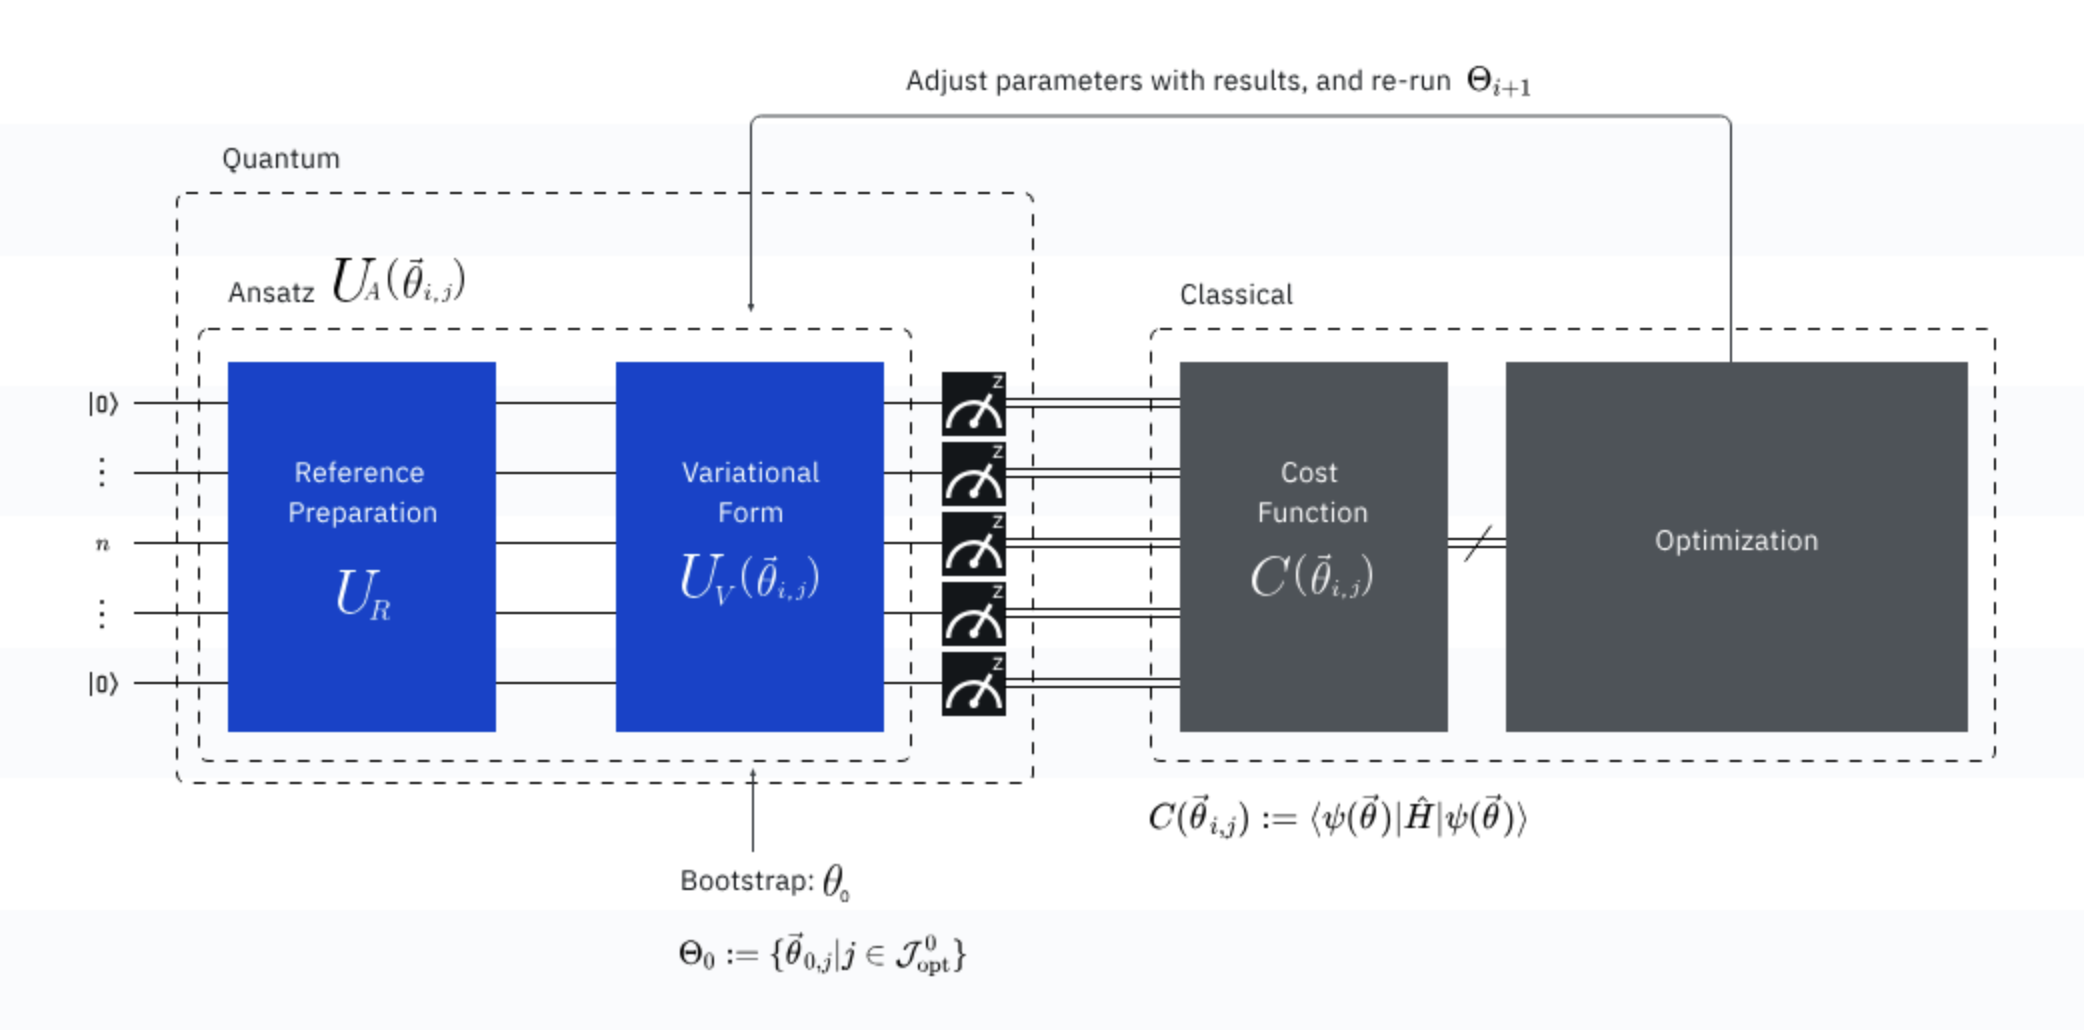

Fig 2. VQE 알고리즘의 계산 워크플로우를 나타낸 도식

VQE의 계산 과정 요약:

1. 양자 상태 $|\psi(𝜃)\rangle$를 준비한다 (양자 단계).
2. 준비된 상태에 대해 해밀토니안의 기댓값 $\langle\psi(𝜃)|\hat{H}|\psi(𝜃)\rangle$ 을 측정한다 (양자 단계).
3. 측정된 결과를 이용하여 비용 함수 $𝐸(𝜃)$ 를 계산한다 (고전 단계).
4. 고전 최적화 기법을 이용해 파라미터 $𝜃$ 를 조정한다 (고전 단계).
5. 비용 함수 $𝐸(𝜃)$ 가 수렴할 때까지 위 단계를 반복한다.

위 과정에서 확인할 수 있듯이, VQE 알고리즘을 실행하기 위한 계산 과정은 본질적으로 반복(iterative) 과정입니다. 즉, 이 일련의 단계를 수차례 반복해야 합니다. 계산 비용이 매우 크기 때문에, 분자 시스템의 크기가 커질수록 계산 비용이 급격히 증가하며, 결과적으로 큰 분자 시스템에 대해 VQE가 효율적으로 확장되는 데 한계로 작용하게 됩니다.

# 3. 샘플 기반 양자 대각화(Sample-based Quantum Diagonalization, SQD)란 무엇인가?

VQE는 2014년 처음 제안된 이후 폭넓게 연구되어 온 알고리즘이지만, 몇 가지 명확한 한계점을 가지고 있습니다. 가장 대표적인 문제점은 시스템의 크기가 증가하여 해밀토니안이 커질수록 변분법을 통한 기댓값의 계산이 기하급수적으로 많은 계산 자원을 요구한다는 것입니다. 따라서 큰 분자 시스템에 대해서는 효율적인 확장성을 확보하기 어렵다는 단점이 있습니다. 이러한 VQE의 확장성 문제는 곧 샘플 기반 양자 대각화(Sample-based Quantum Diagonalization, SQD) 알고리즘을 연구 개발하게 되는 계기가 되었습니다.

SQD는 [이 논문](https://arxiv.org/abs/2302.11320)에서 처음 논의된 양자 선택적 배치 상호작용(Quantum-selected Configuration Interaction, QSCI)이라는 하이브리드 양자-고전 방법에서 영감을 얻어 개발된 알고리즘입니다. QSCI와 마찬가지로, SQD 역시 하이브리드 양자-고전 알고리즘이며, 그 기본 원리는 다음과 같습니다. 먼저 양자 컴퓨터는 특정 양자회로를 통해 전자 배치를 양자 상태로부터 샘플링합니다. 이렇게 샘플링을 통해 얻은 전자 배치는 해밀토니안의 표현을 위한 부분공간을 형성하는 데 사용되며, 최종적으로는 이 부분공간으로 해밀토니안을 투영(project)하고 대각화하여 고유 에너지를 계산하는 방식입니다.

이렇게 구성된 부분공간은 원래 해밀토니안의 차원보다 훨씬 작으므로, 고전적인 방법으로 대각화하는 과정이 크게 단순해지고 계산 부담이 줄어들게 됩니다.

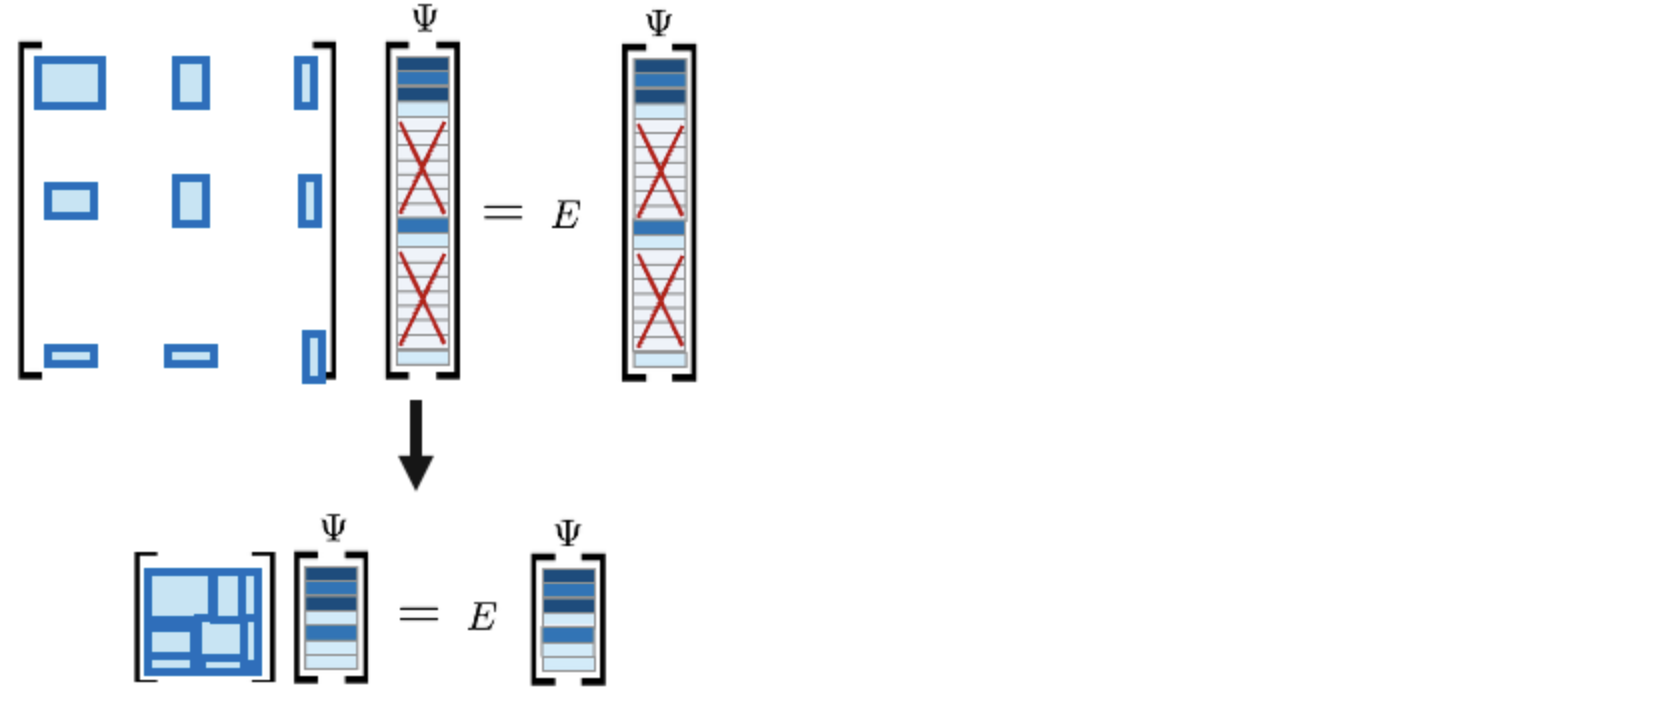

Fig 3. 원래의 해밀토니안은 N개의 큐비트로 구성된 힐베르트 공간에서 지수적으로 큰 행렬 형태로 나타나지만, 전자 배치 추출 및 샘플링을 수행한 이후에는 그 크기가 훨씬 작은 행렬로 축소될 수 있음을 나타낸 도식.


세 개의 원자 오비탈인 1s, 2s, 3p가 있고, 낮은 에너지에서 높은 에너지 순으로 배열된 이 오비탈을 두 개의 전자가 점유한다고 가정해 봅시다. 일반적으로, 낮은 에너지의 전자 배치는 전자들이 주로 하위 오비탈에 존재하는 상태를 의미하며, 높은 에너지의 전자 배치는 전자들이 주로 상위 오비탈에 존재하는 상태를 의미합니다. SQD 알고리즘의 중요한 가정 중 하나는 높은 에너지에 해당하는 전자 배치가 바닥상태에 크게 기여하지 한다는 것입니다. 이와 같은 가정을 통해, 바닥상태의 에너지 계산에서 기여도가 미미한 높은 에너지의 전자 배치를 효과적으로 제거할 수 있게 됩니다. 이렇게 하면 낮은 에너지의 오비탈들을 주로 점유하는, 바닥상태에 가장 관련성이 높은 전자 배치만으로 이루어진 부분공간에 초점을 맞추는 것이 가능해집니다.

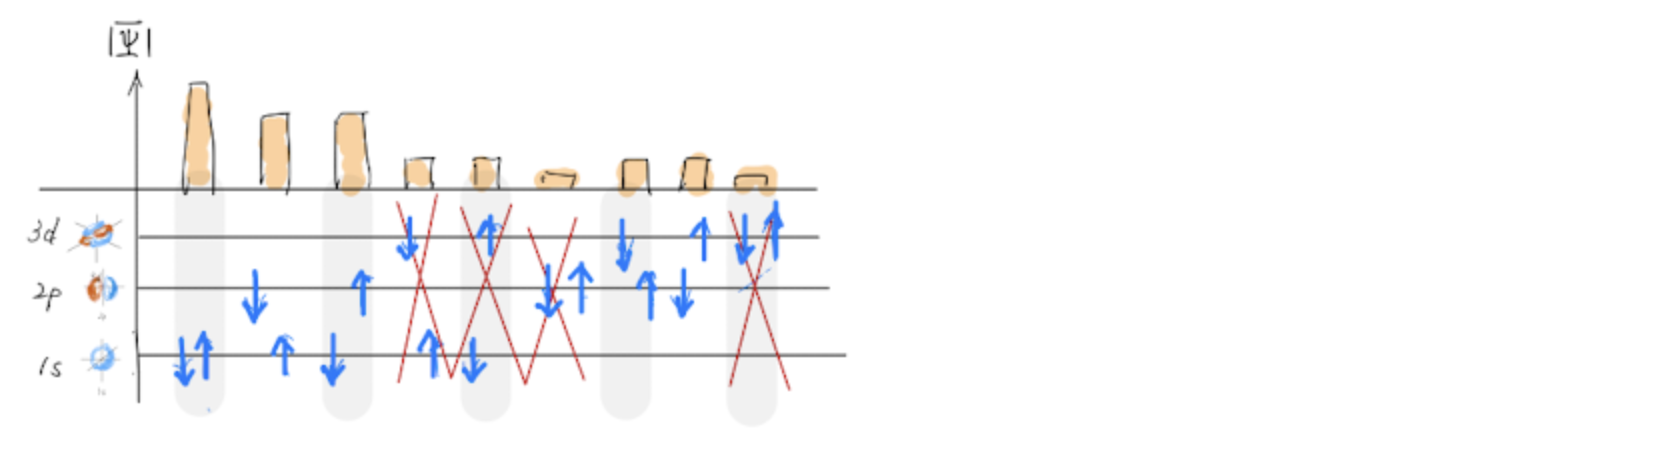

Fig 4. 바닥상태와 관련이 적은 전자 배치를 제거함으로써 행렬(해밀토니안)의 크기를 효과적으로 축소할 수 있음을 나타낸 도식


이러한 방식으로 해밀토니안을 더 작은 크기로 재구성하면, 바닥상태 에너지와 같은 목표 해(solution)에 도달하기까지 소요되는 계산 시간이 현저히 단축됩니다.

## 관련성 있는 전자 배치의 선택 방법

관련성 있는 전자 배치를 식별하기 위해, 도식에서 $|\psi\rangle$로 표현된 특정 양자 회로(ansatz)를 사용합니다. 이 양자 회로를 계산 기저에서 측정하면, 힐베르트 공간 전체에 걸친 확률 분포를 얻게 되고, 이를 바탕으로 필요한 비트열을 샘플링 할 수 있습니다.

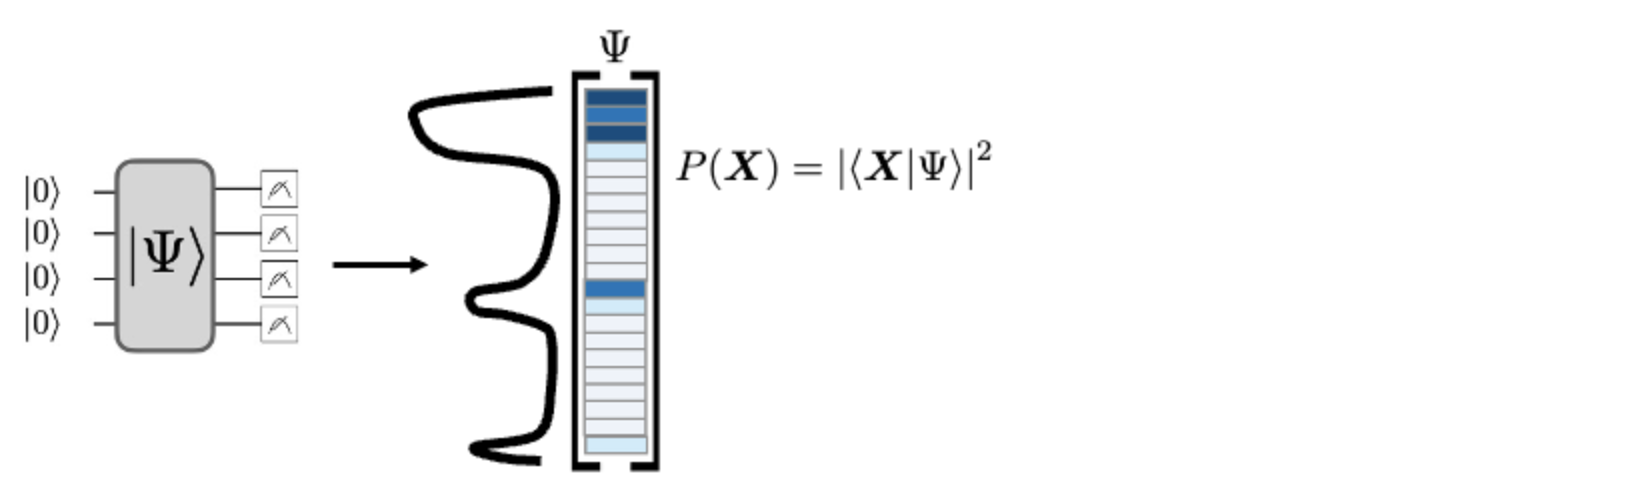

Fig 5. 양자 'ansatz' 회로로부터 측정된 비트열을 샘플링하는 과정을 나타낸 도식

## 전자 배치 복원(Configuration Recovery)을 통한 노이즈 영향 처리 방법

양자 회로로부터 생성된 비트열에서 샘플링을 수행하기 이전에, 양자 시스템의 노이즈로 인해 에너지 계산 정확도에 영향을 미칠 수 있는 '노이즈가 포함된 양자 샘플(noisy quantum samples)'을 다룰 필요가 있습니다. 이때 중요한 역할을 하는 것이 바로 전자 배치 복원 기법입니다. 예를 들어, 특정 비트열의 전자 배치에 전자 하나가 빠져 있는 경우를 생각해 봅시다. 이 경우는 해밍 무계가 정확한 값과 다르기 때문에 쉽게 식별할 수 있습니다. 이때 서로 다른 오비탈의 점유율의 기댓값(아래 도식에서 $n$ 으로 표현됨)을 이용하여, 잘못된 비트가 무엇인지 판단하고, 해당 비트를 다시 뒤집어 올바른 비트열로 복원할 수 있습니다.

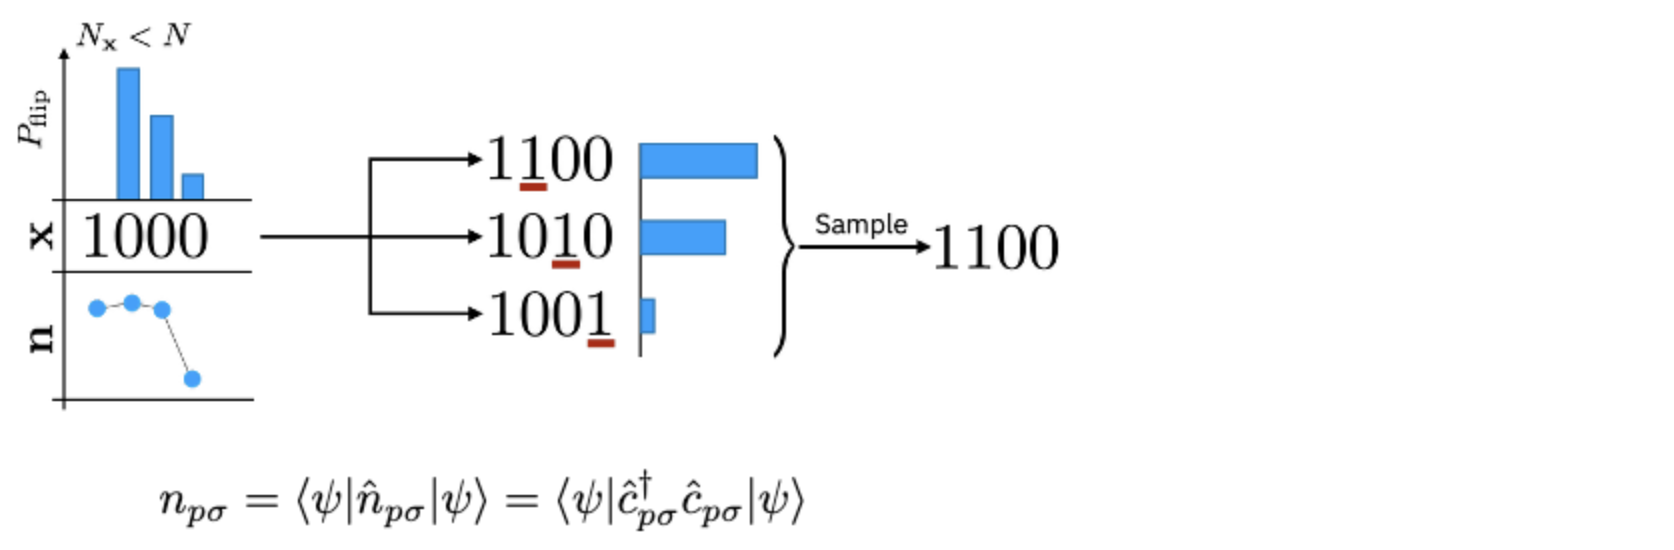

Fig 6. 전자의 개수 및 오비탈의 점유 기댓값을 확인함으로써, 잘못된 비트를 찾아 뒤집을 수 있음을 나타낸 도식

양질의 샘플을 사용하여 해밀토니안을 재구성한 이후, 이제 대각화가 가능한 축소된 크기의 행렬을 가지게 됩니다. 이렇게 형성된 부분공간에서 해밀토니안을 대각화하면, 대각화 알고리즘은 문제의 바닥상태에 기여하는 계산기저 상태들에 대해 0이 아닌 파동함수 진폭을 부여하게 됩니다. 같은 과정에서, 바닥상태에 거의 기여하지 않는 비트열에는 0에 가까운 진폭을 할당합니다. 이러한 일련의 과정을 모든 배치(batch)에 대해 반복하여 얻은 결과로부터, SQD 알고리즘은 각 오비탈의 전자 점유율 및 최저 에너지 추정값을 얻게 되며, 이 정보를 다음번 전자 배치 복원 과정에서 활용할 데이터로 업데이트합니다.

# 4. SQD를 이용한 $N_2$ 분자의 시뮬레이션

이번 세션에서는 노이즈가 포함된 양자 샘플을 후처리하여 화학적 해밀토니안의 바닥상태를 근사적으로 나타내는 과정을 시연해 보겠습니다. 예시로 다룰 시스템은 평형 상태(equilibrium)에 있는 질소 분자($N_2$)이며, 6-31G 기저 집합을 사용하였습니다. 구체적으로, 36개의 큐비트로 이루어진 양자 ansatz 회로(이 경우 LUCJ 회로)를 이용하여 얻은 샘플을 처리하는 데 SQD 알고리즘을 적용할 것입니다. 양자 노이즈의 영향을 보정하기 위해 전자 배치 복원 기법을 사용합니다.

## 분자 해밀토니안

분자의 다양한 화학적 성질은 주로 그 내부 전자 구조에 의해 결정됩니다. 전자는 페르미온이라는 입자의 특성을 가지며, 페르미온의 물리적 상태를 표현하는 수식으로 2차 양자화(second quantization)라는 방법이 널리 사용됩니다. 2차 양자화의 핵심 아이디어는 다음과 같습니다. 분자 시스템을 구성하는 여러 개의 오비탈이 있고, 각 오비탈은 페르미온이 점유하거나 점유하지 않는 상태 중 하나를 취할 수 있습니다. 총 $N$ 개의 오비탈로 구성된 시스템은 일련의 페르미온 소멸 연산자(fermionic annihilation operators) $\{\hat{a}_p\}_{p=1}^N$ 로 기술되며, 다음과 같은 페르미온 반교환 관계(fermionic anticommutation relations)를 만족합니다.

$$
\begin{align*}
\hat{a}_p \hat{a}_q + \hat{a}_q \hat{a}_p &= 0, \\
\hat{a}_p \hat{a}_q^\dagger + \hat{a}_q^\dagger \hat{a}_p &= \delta_{pq}.
\end{align*}
$$

연산자 $\hat{a}_p$의 에르미트 수반(Hermitian adjoint)인 $\hat{a}_p^\dagger$는 생성 연산자(creation operator)라고 부릅니다.

지금까지의 설명에서는 페르미온의 근본적 특성 중 하나인 스핀을 고려하지 않았습니다. 스핀을 고려하게 되면, 오비탈은 쌍을 이루어 *공간 오비탈*로 표현됩니다. 각 공간 오비탈은 두 개의 *스핀 오비탈*로 구성되며, 이 두 스핀 오비탈은 각각 "스핀-$\alpha$"와 "스핀-$\beta$"로 표시됩니다. 이때, 공간 오비탈 $p$에 속하면서 스핀 $\sigma$ ($\sigma \in \{\alpha, \beta\}$) 를 가지는 스핀 오비탈에 대응되는 소멸 연산자를 $\hat{a}_{p\sigma}$ 로 표기합니다. 만약 공간 오비탈의 총 개수를 $N$ 이라고 하면, 전체 스핀 오비탈의 수는 $2N$ 개가 됩니다. 이러한 시스템의 힐베르트 공간은 다음과 같은 두 부분의 비트열로 표기되는 총 $2^{2N}$ 개의 직교 정규 기저(orthonormal basis)에 의해 생성됩니다.

$$
\lvert z \rangle = \lvert z_\beta z_\alpha \rangle = \lvert z_{\beta, N} \cdots z_{\beta, 1} z_{\alpha, N} \cdots z_{\alpha, 1} \rangle.
$$

분자 시스템의 해밀토니안은 다음과 같은 형태로 표현할 수 있습니다.

$$
\hat{H} = \sum_{ \substack{pr\\\sigma} } h_{pr} \, \hat{a}^\dagger_{p\sigma} \hat{a}_{r\sigma}
+ \frac12
\sum_{ \substack{prqs\\\sigma\tau} }
h_{prqs} \, 
\hat{a}^\dagger_{p\sigma}
\hat{a}^\dagger_{q\tau}
\hat{a}_{s\tau}
\hat{a}_{r\sigma}.
$$

여기서 $h_{pr}$ 및 $h_{prqs}$는 분자 적분(molecular integrals) 이라 불리는 복소수로, 이 값들을 주어진 분자의 구조와 특성을 컴퓨터 프로그램을 사용하여 계산할 수 있습니다. 본 실습에서는 이 분자 적분을 [PySCF](https://pyscf.org/) 소프트웨어 패키지를 이용하여 계산합니다.

분자의 해밀토니안이 유도되는 자세한 과정에 관해서는 양자화학 교과서(예: *Modern Quantum Chemistry* by Szabo and Ostlund)를 참고하시기를 바랍니다.

## 국소 유니터리 클러스터 자스트로(Local Unitary Cluster Jastrow, LUCJ) 가설해

SQD 알고리즘을 적용하기 위해서는 샘플을 추출할 수 있는 양자 회로 가설해가 필요합니다. 본 실습에서는 물리적 타당성과 하드웨어 친화성을 모두 만족하는 [국소 유니터리 클러스트 자스트로(Local Unitary Cluster Jastrow, LUCJ)](https://pubs.rsc.org/en/content/articlelanding/2023/sc/d3sc02516k) 가설해[1]를 사용하겠습니다.

LUCJ 가설해는 일반적인 유니터리 클러스터 자스트로(UCJ) 가설해의 특수한 형태로, UCJ 가설해는 다음과 같은 형식으로 표현됩니다.

$$
  \lvert \Psi \rangle = \prod_{\mu=1}^L e^{\hat{K}_\mu} e^{i \hat{J}_\mu} e^{-\hat{K}_\mu} | \Phi_0 \rangle
$$

여기서 $\lvert \Phi_0 \rangle$는 참조 상태(reference state)로, 일반적으로 하트리-폭(Hartree-Fock, HF) 상태를 사용합니다. 또한 연산자 $\hat{K}_\mu$ 와 $\hat{J}_\mu$ 는 각각 다음과 같이 정의됩니다.

$$
\hat{K}_\mu = \sum_{pq, \sigma} K_{pq}^\mu \, \hat{a}^\dagger_{p \sigma} \hat{a}^{\phantom{\dagger}}_{q \sigma}
\;,\;
\hat{J}_\mu = \sum_{pq, \sigma\tau} J_{pq,\sigma\tau}^\mu \, \hat{n}_{p \sigma} \hat{n}_{q \tau}
\;
$$

여기서 $\hat{n}_{p \sigma}$는 오비탈 점유 수 연산자(number operator)로, 다음과 같이 정의됩니다.

$$
\hat{n}_{p \sigma} = \hat{a}^\dagger_{p \sigma} \hat{a}^{\phantom{\dagger}}_{p \sigma}
$$

연산자 $e^{\hat{K}_\mu}$ 는 오비탈 회전을 나타내며, 알려진 알고리즘을 통해 선형 깊이와 선형 연결성으로 효율적으로 구현할 수 있습니다.
반면, UCJ 가설해의 $e^{i \mathcal{J}_k}$ 항은 모든 큐비트 간 상호 연결성(all-to-all connectivity)을 필요로 하거나 페르미온 교환 네트워크(fermionic swap network)를 사용해야 하므로, 연걸성이 제한적인 노이즈가 있는 결함 허용 전의 (pre-fault-tolerant) 양자 프로세서에서는 구현하기가 어렵습니다.
이러한 문제를 해결하기 위해 제안된 것이 바로 *국소* UCJ 가설해이며, 이 가설해는 $\mathbf{J}^{\alpha\alpha}$ 와 $\mathbf{J}^{\alpha\beta}$에 희소성(sparsity) 제약 조건을 적용함으로써 제한된 연결성을 가진 큐비트 위상에서도 일정한 깊이로 구현이 가능합니다. 여기서 $\mathbf{J}^{\alpha\alpha}$ 와 $\mathbf{J}^{\alpha\beta}$는 각각 다음과 같이 정의됩니다.

$$
\mathbf{J}^{\alpha\alpha}= J_{p q,\alpha\alpha}^1 \qquad \mathbf{J}^{\alpha\beta}= J_{p q,\alpha\beta}^1
$$

IBM의 하드웨어에서는 중 육각 격자(heavy-hex lattice)라는 큐비트 위상구조를 사용하며, 이 경우 다음과 같은 "지그재그" 패턴을 적용할 수 있습니다.
이 지그재그 패턴에서 동일한 스핀을 가진 오비탈을 선형 위상을 가진 큐비트에 대응하여 배치되며(빨간색과 파란색 원), 서로 다른 스핀을 가진 오비탈 간 연결성은 매 4번째 공간 오비탈마다 이루어지고, 이 연결은 보조 큐비트(ancillary qubit, 보라색 원)를 통해 실현됩니다. 이때 적용되는 인덱스 제약 조건은 다음과 같습니다.

$$
\begin{align*}
\mathbf{J}^{\alpha\alpha} &: \{(p, p+1) \; , \; p = 0, \ldots, N-2\} \\
\mathbf{J}^{\alpha\beta} &: \{(p, p) \;, \; p = 0, 4, 8, \ldots,\; p \leq N-1\}
\end{align*}
$$




Fig 7. IBM 양자 하드웨어의 중 육각 격자 큐비트 위상구조를 나타낸 도식

## 샘플 기반 양자 대각화(Sample-based Quantum Diagonalization, SQD)

자기 일관적 전자 배치 복원(self-consistent configuration recovery) 과정은 노이즈가 포함된 양자 샘플로부터 가능한 많은 유의미한 신호를 추출하기 위해 설계된 방법입니다. 이 과정은 반복적인 루프를 통해 실행되며, 각 반복은 다음의 네 가지 단계로 구성됩니다.

1. **전자 배치 복원**: 특정한 대칭성을 위반하는 모든 비트열에 대해, 현재 추정된 평균 오비탈 점유율에 더 가까워지도록 설계된 확률적 방법을 이용해 비트를 뒤집어 새로운 비트열을 생성합니다.
2. **부분 샘플링**: 원본 비트열과 새롭게 복원된 비트열 중, 대칭성 조건을 만족하는 비트열을 모두 모으고, 미리 정해진 크기의 부분집합으로 샘플링 합니다.
3. **부분공간에서의 대각화**: 각 비트열 부분집합에 대해, 해당 비트열로 정의된 기저 벡터에 의해 생성되는 부분공간으로 해밀토니안을 투영하고, 이를 고전 컴퓨터로 대각화하여 부분공간 내의 바닥상태 에너지를 근사적으로 계산합니다.
4. **최저 에너지 결정**: 계산된 모든 바닥상태 추정값들 중에서 가장 낮은 에너지 값을 갖는 상태를 선택하여, 이 정보를 바탕으로 평균 오비탈 점유율의 추정치를 업데이트합니다.

SQD 알고리즘의 전체적인 워크플로우는 다음의 도식에서 나타냅니다.



Fig 8. SQD 워크플로우를 나타내는 도식

SQD 알고리즘은 목표로 하는 고유상태의 파동함수가 희소성을 가질 때 특히 우수한 성능을 나타냅니다. 즉, 파동함수의 진폭이 0이 아닌 값을 가지는 기저 상태들의 집합 $\mathcal{S} = \{|x\rangle \}$ 의 크기가 문제의 크기 (size of the problem)가 증가함에 따라 기하급수적으로 늘어나지 않을 때, SQD가 효과적으로 작동하는 것으로 알려져 있습니다.

### 전자 배치 복원 루프 1: 전자 배치 복원 단계

전자 배치 복원 루프의 첫 번째 단계는 전자 배치를 복원하는 것입니다. 즉, 이 단계에서는 오류완화(error mitigation)가 수행됩니다.

위에서 구성된 LUCJ 가설해에 해당하는 양자 회로를 실제 양자 컴퓨터에서 실행하면, 왼쪽 하단 그림과 같은 비트열과 그 출현 횟수 형태의 결과를 얻을 수 있습니다. 그러나 현재의 양자 컴퓨터는 노이즈로 인해 결과에 오류가 포함될 수밖에 없습니다. 문제로 주어진 분자는 "스핀-$\alpha$" 와 "스핀-$\beta$" 각각의 입자 수가 고정되어 있으므로, 입자 수가 정확히 표현되도록 결과로 얻은 비트열의 일부 비트를 뒤집어 오류를 교정할 수 있습니다.

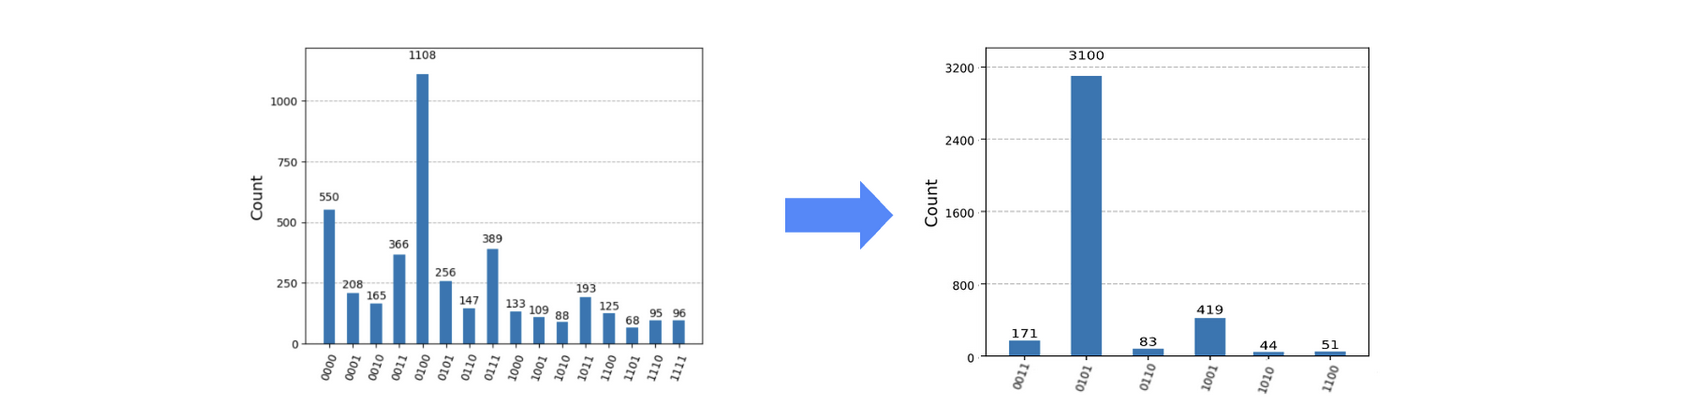

Fig 9. LUCJ 가설해 회로로부터 초기 생성된 비트열 (왼쪽) 과 오류 교정을 통해 복원된 비트열 (오른쪽)

예를 들어, 4개의 스핀 오비탈을 고려하는 문제에서 "스핀-$\alpha$" 전자 2개와 "스핀-$\beta$" 전자 2개를 가진 분자를 생각해 보겠습니다. 만약 오비탈이 낮은 에너지 준위부터 차례대로 채워진다면, 양자 상태는 아래 왼쪽 그림과 같이 |0011 0011>로 표현될 것입니다.
이때 양자 컴퓨터 실행 결과가 |1110 0011>로 나타났다고 한다면, "스핀-$\beta$" 전자가 3개로 너무 많으므로, 이중 하나의 비트를 1에서 0으로 뒤집어 전자의 수가 정확히 2개가 되도록 교정할 수 있습니다.
또한 |0011 0001> 이 관측된 경우를 생각해 보면, "스핀-$\alpha$" 전자가 1개로 부족한 상태이므로, 0으로 표현된 비트 중 하나를 1로 뒤집어서 정확히 두 개의 "스핀-$\alpha$" 전자가 존재하도록 비트열을 교정할 수 있습니다.

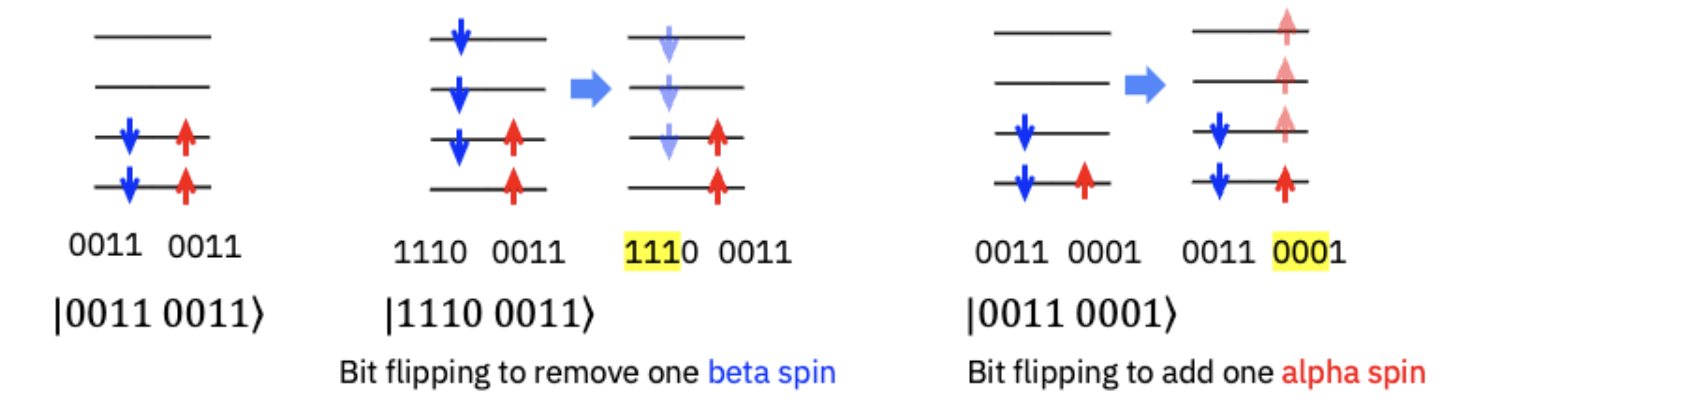

Fig 10. 전자의 수와 각 오비탈의 점유 기댓값을 바탕으로 최대 가중 확률 방법을 사용하여 비트열을 교정하는 과정의 도식

이때, 어떤 전자에 해당하는 비트를 뒤집을지 결정할 때는 각 오비탈의 평균 점유율을 사용하여, 비트를 뒤집을 확률이 최대인 전자를 선택합니다.
평균 오비탈 점유율은 전자 배치 복원 루프의 마지막 단계에서 계산됩니다. 따라서 첫 번째 루프에서는 아직 계산된 평균 점유율이 존재하지 않으므로 이 방법을 사용하지 않으며, 잘못된 입자 수를 가진 샘플들은 모두 버리게 됩니다.

### 전자 배치 복원 루프 2: 부분 샘플링

다음 단계는 앞 단계에서 오류가 교정된 샘플들 중에서 일부를 선택하는 것입니다.
예를 들어, 이번 경우에는 100,000회의 측정이 이루어졌으므로, 여기서 무작위 50개의 샘플을 추출하는 과정을 5회 반복하여, 총 5개의 배치(batch)를 얻을 수 있습니다. 큰 분자 시스템을 다룰 경우, 배치 단위로 처리하면서 슈퍼컴퓨터에서 병렬 계산이 가능합니다.

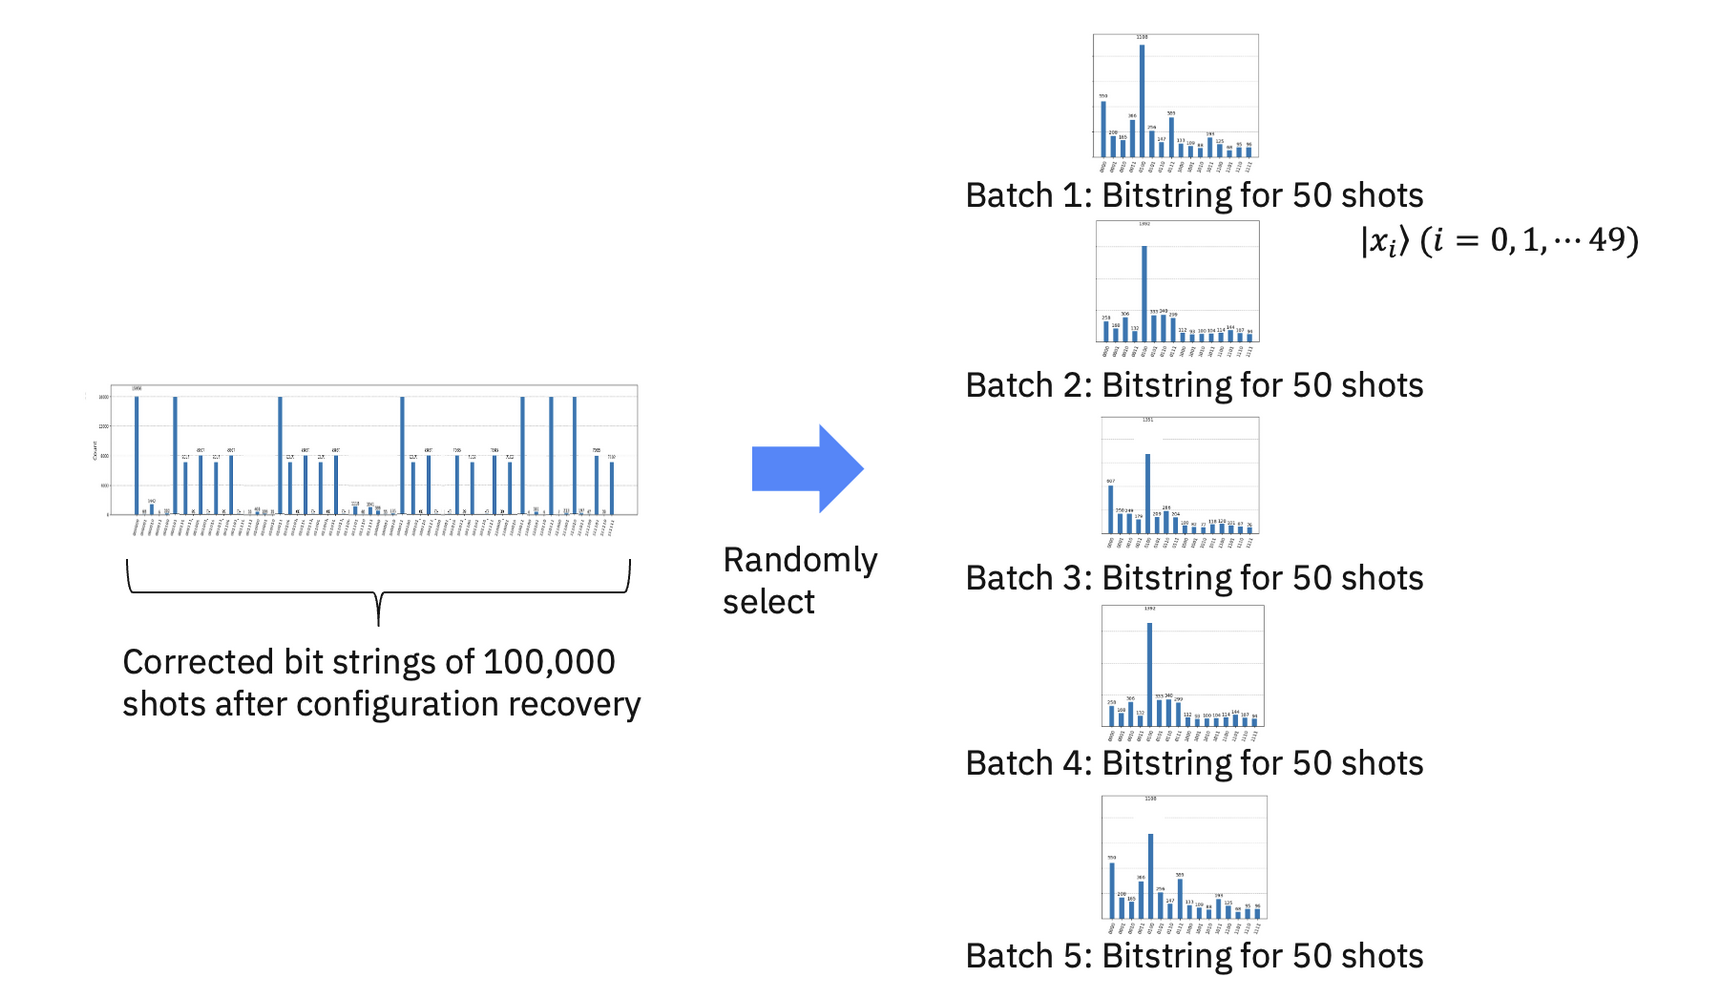

Fig 11. 오류가 정정된 샘플들로부터의 부분 샘플링 과정

### 전자 배치 복원 루프 3: 부분공간에서의 대각화 

다음 단계는 부분공간에서의 해밀토니안 대각화입니다. 앞서 예시로 든 문제에서 원래 해밀토니안 $H$ 은 $2^{32}\times2^{32}$ 크기의 행렬입니다. 이 행렬을 50개의 비트열, 즉 $|x_i\rangle$ 로 생성된 부분공간으로 투영하여 크기를 축소한 후 이를 대각화합니다.
이 투영 행렬 $P_S$는 이론적으로 0...0 부터 1...1 까지 총 $2^{32}$ 개의 가능한 모든 비트열을 가질 수 있으나, 실제로 측정된 최대 50개의 비트열만을 포함하게 됩니다. $P_S$는 대각에 50개의 원소만이 1을 가지고 나머지 원소는 모두 0으로 구성된 행렬입니다.
따라서, 원래 해밀토니안 $H$ 와 투영 행렬 $P_S$ 를 곱하여 얻은 축소된 해밀토니안은 오직 $50\times50$개 이고, 나머지 원소들은 전부 0입니다. 결국, 원래 크기인 $2^{32}\times2^{32}$ 의 거대한 행렬 대신 $50\times50$ 크기의 작은 행렬만을 대각화하면 됩니다.

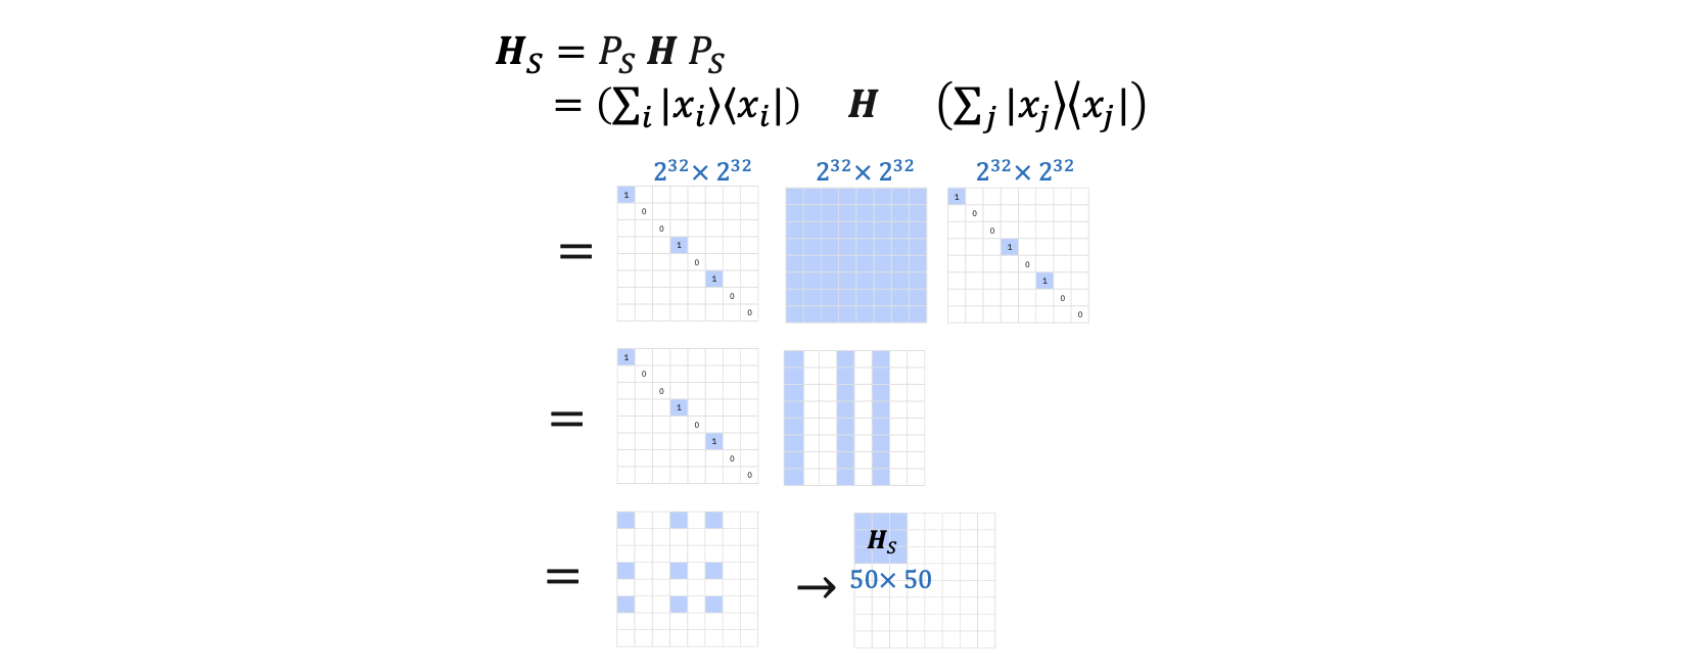

Fig 12. 부분공간에서의 행렬 대각화 과정을 나타낸 도식

### 전자 배치 복원 루프 4: 최저 에너지 계산

마지막으로, 앞서 수행한 모든 배치의 결과로부터 평균 오비탈 점유율에 대해 추정값과 바닥상태에 해당하는 최저 에너지를 얻습니다. 이 정보를 다음 반복을 위한 데이터로 업데이트합니다.

## Qiskit pattern

SQD 알고리즘을 다음과 같이 Qiskit pattern을 활용하여 구현할 수 있습니다:

1. **Step 1: 양자 문제로 정의**
    - 바닥상태를 추정하기 위해 가설해를 생성합니다.
2. **Step 2: 문제 최적화**
    - 사용하고자 하는 양자 하드웨어(backend)에 맞게 가설해 회로를 트랜스파일합니다.
3. **Step 3: 실험 실행**
    - Qiskit의 ``Sampler`` primitive을 이용하여 가설해 회로로부터 비트열 샘플을 수집합니다.
4. **Step 4: 결과 후처리**
    - 자기 일관적 전자 배치 복원 루프를 수행합니다.
        - 입자 수에 대한 사전 정보와 이전 반복에서 계산된 평균 오비탈 점유율을 사용하여 전체 비트열 샘플을 후처리 합니다.
        - 복원된 비트열로부터 부분 샘플을 확률적으로 생성하여 배치를 구성합니다.
        - 각 부분공간에 대해 분자 해밀토니안을 투영하고, 축소된 행렬을 고전적으로 대각화합니다.
        - 모든 배치에서 얻어진 바닥상태 에너지 추정값 중 최솟값을 선택하고, 이를 바탕으로 평균 오비탈 점유율을 업데이트합니다.

## Step 1: Map classical inputs to a quantum problem

We will find an approximation to the ground state of the molecule at equilibrium in the 6-31G basis set. First, we specify the molecule and its properties.


In [7]:
warnings.filterwarnings("ignore")

# 분자의 성질 특정
open_shell = False
spin_sq = 0

# N2 분자 구축
mol = pyscf.gto.Mole()
mol.build(
    atom=[["N", (0, 0, 0)], ["N", (1.0, 0, 0)]],
    basis="6-31g",
    symmetry="Dooh",
)

# 활성 공간 정의
n_frozen = 2
active_space = range(n_frozen, mol.nao_nr())

# 분자 적분 계산
scf = pyscf.scf.RHF(mol).run()
num_orbitals = len(active_space)
n_electrons = int(sum(scf.mo_occ[active_space]))
num_elec_a = (n_electrons + mol.spin) // 2
num_elec_b = (n_electrons - mol.spin) // 2
cas = pyscf.mcscf.CASCI(scf, num_orbitals, (num_elec_a, num_elec_b))
mo = cas.sort_mo(active_space, base=0)
hcore, nuclear_repulsion_energy = cas.get_h1cas(mo)
eri = pyscf.ao2mo.restore(1, cas.get_h2cas(mo), num_orbitals)

# 분자의 정확한 에너지 계산
exact_energy = cas.run().e_tot

converged SCF energy = -108.835236570774
CASCI E = -109.046671778080  E(CI) = -32.8155692383187  S^2 = 0.0000000


`LUCJ` 가설해 회로를 구성하기 전에, 다음 코드 셀에서 CCSD 계산을 먼저 수행합니다. 여기서 얻어진 [$t_1$ 및 $t_2$ 진폭](https://en.wikipedia.org/wiki/Coupled_cluster#Cluster_operator)은 이후 가설해의 매개변수 초기화에 사용됩니다.

In [8]:
# 가설해의 초기 매개변수로 사용할 CCSD의 t1, t2 진폭을 계산
ccsd = pyscf.cc.CCSD(scf, frozen=[i for i in range(mol.nao_nr()) if i not in active_space]).run()
t1 = ccsd.t1
t2 = ccsd.t2

E(CCSD) = -109.0398256929733  E_corr = -0.2045891221988307


이제, [ffsim](https://github.com/qiskit-community/ffsim)을 이용하여 가설해 회로를 구성합니다. 고려하는 분자는 닫힌 껍질(closed-shell)의 하트리-폭 상태를 가지므로, 스핀 균형을 이루는 UCJ 가설해 변형인 [UCJOpSpinBalanced](https://qiskit-community.github.io/ffsim/api/ffsim.html#ffsim.UCJOpSpinBalanced)를 사용합니다. 이때 상호작용 쌍은 중 육각 격자 큐비트 위상구조에 적합하도록 설정하여 전달합니다.

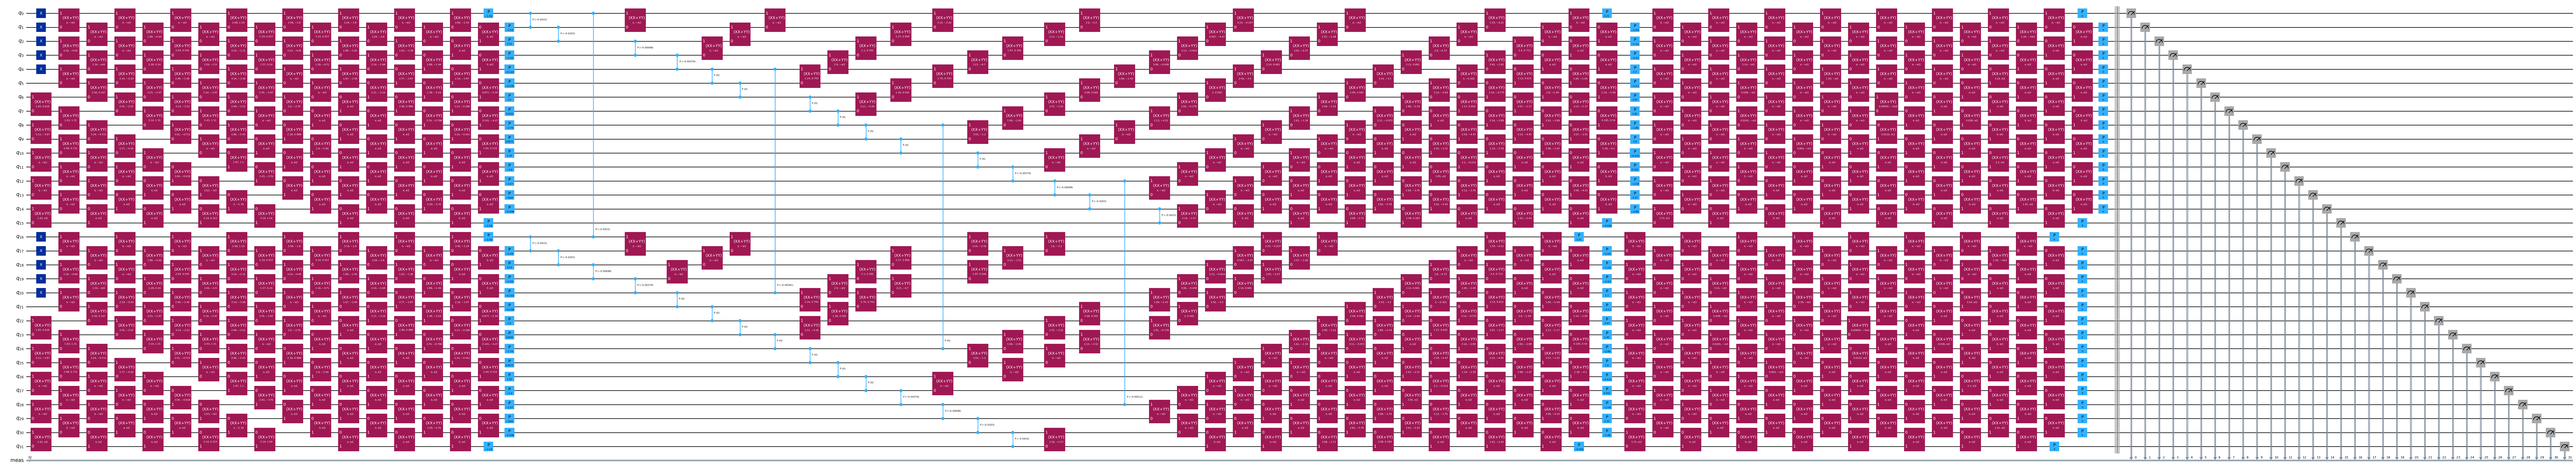

In [9]:
n_reps = 1
alpha_alpha_indices = [(p, p + 1) for p in range(num_orbitals - 1)]
alpha_beta_indices = [(p, p) for p in range(0, num_orbitals, 4)]

ucj_op = ffsim.UCJOpSpinBalanced.from_t_amplitudes(
    t2=t2,
    t1=t1,
    n_reps=n_reps,
    interaction_pairs=(alpha_alpha_indices, alpha_beta_indices),
)

nelec = (num_elec_a, num_elec_b)

# 빈 양자회로 생성
qubits = QuantumRegister(2 * num_orbitals, name="q")
circuit = QuantumCircuit(qubits)

# 하트리-폭 상태 상태를 준비하여 양자회로에 추가
circuit.append(ffsim.qiskit.PrepareHartreeFockJW(num_orbitals, nelec), qubits)

# UCJ 연산자 적용
circuit.append(ffsim.qiskit.UCJOpSpinBalancedJW(ucj_op), qubits)
circuit.measure_all()

circuit.decompose().decompose().draw("mpl", fold =-1)

## Step 2: 양자 실행을 위한 문제 최적화
다음 단계는 양자 하드웨어에서 실행할 수 있도록 양자 회로를 최적화하는 것입니다. 여기서는 127-큐비트 QPU인 `ibm_brisbane`을 사용합니다.

In [10]:
service = QiskitRuntimeService(channel="ibm_quantum_platform")
backend = service.backend("ibm_brisbane")

가설해를 최적화하고 양자 하드웨어와의 호환성을 높이기 위해 다음과 같은 절차를 권장합니다.

* 목표 하드웨어로부터 위에서 설명한 지그재그 패턴에 적합한 물리적 큐비트 배치(`initial_layout`)를 선택합니다. 이 방식으로 큐비트를 배치하면 하드웨어와 호환되는 효율적인 양자 회로를 구성할 수 있으며, 회로의 전체 게이트 수를 최소화할 수 있습니다.
* 선택한 `backend`와 위에서 결정한 `initial_layout`을 사용하여 Qiskit의 [generate\_preset\_pass\_manager](https://quantum.cloud.ibm.com/docs/en/api/qiskit/qiskit.transpiler.generate_preset_pass_manager)함수를 통해 단계화된 패스 매니저(pass manager)를 생성합니다.
* 생성된 단계화된 패스 매니저의 `pre_init`단계를 `ffsim.qiskit.PRE_INIT`으로 설정합니다. `ffsim.qiskit.PRE_INIT`은 게이트를 오비탈 회전으로 분해한 뒤, 병합하는 Qsikit 트랜스파일러 패스를 포함하며, 그 결과 최종 양자 회로의 게이트 수가 감소하게 됩니다.
* 마지막으로 위에서 구성된 패스 매니저를 양자 회로에 실행합니다.

In [11]:
spin_a_layout = [0, 14, 18, 19, 20, 33, 39, 40, 41, 53, 60, 61, 62, 72, 81, 82]
spin_b_layout = [2, 3, 4, 15, 22, 23, 24, 34, 43, 44, 45, 54, 64, 65, 66, 73]
initial_layout = spin_a_layout + spin_b_layout

pass_manager = generate_preset_pass_manager(
    optimization_level=3, backend=backend, initial_layout=initial_layout
)

# 하드웨어 실행을 위해 이 패스 매니저에 의해 생성된 회로를 사용
pass_manager.pre_init = ffsim.qiskit.PRE_INIT
isa_circuit = pass_manager.run(circuit)
print(f"Gate counts (w/ pre-init passes): {isa_circuit.count_ops()}")

Gate counts (w/ pre-init passes): OrderedDict([('rz', 2466), ('sx', 2161), ('ecr', 730), ('x', 75), ('measure', 32), ('barrier', 1)])


## Step 3: Qiskit Primitive를 이용한 양자 회로 실행

하드웨어 실행을 위해 최적화된 양자 회로가 준비되었으므로, 이제 이 회로를 실제 양자 하드웨어에서 실행하여 바닥상태 에너지 추정을 위한 샘플을 수집할 수 있습니다.

<div class="alert alert-block alert-warning">
    
⚠️ **주의:** QPU에서 회로를 실행하는 부분의 코드는 주석 처리하여 사용자 참고용으로 남겨 두었습니다. 본 실습에서는 실제 하드웨어에서 회로를 실행하는 대신, 이전에 `ibm_brisbane` 양자 프로세서에서 미리 추출해 둔 100,000개의 샘플을 불러와 사용합니다.

</div>

In [12]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

sampler = Sampler(mode=backend)
job = sampler.run([isa_circuit], shots=10_000)
primitive_result = job.result()
pub_result = primitive_result[0]
bit_array = pub_result.data.meas

bit_array = np.load('utils/N2_device_bitarray.npy', allow_pickle=True).item()

## Step 4: 후처리 및 고전적인 결과 형식으로 반환

앞서 말했듯이, 자기 일관적 전자 배치 복원 과정은 반복 루프를 통해 실행됩니다.
다음 코드 셀에서는 루프의 첫 번째 반복에서 원본 샘플을 그대로 사용합니다(단, 대칭성을 위반하는 샘플을 배제한 이후). 이후, 이 샘플을 대각화 절차의 입력으로 전달하여 평균 오비탈 점유율에 대한 초기 추정값을 얻습니다.
두 번째 반복부터는 이전에 얻은 평균 오비탈 점유율을 이용하여, 원본 샘플 중 대칭성을 위반하는 샘플을 수정하여 새로운 전자 배치를 생성합니다.
이렇게 얻어진 새로운 전자 배치를 수집한 후 다시 부분 샘플링 하여 배치를 구성하고, 이 배치를 이용하여 해밀토니안을 축소 투영한 뒤, 축소된 해밀토니안의 고유상태 계산기(eigenstate solver)를 통해 바닥상태 에너지를 근사적으로 계산합니다.

이 기법에서 사용자가 제어할 수 있는 몇 가지 중요한 옵션들이 있습니다:

* `max_iterations`: 자기 일관적 전자 배치 복원 루프를 수행할 총 반복의 횟수입니다.
* `num_batches`: 부분 샘플링으로 생성할 전자 배치들의 배치 개수이며, 이는 고유상태 계산기를 호출하는 횟수와 동일합니다.
* `samples_per_batch`: 각 배치에 포함할 서로 다른 고유한 전자 배치의 개수입니다.
* `max_cycles`: 고유상태 계산기가 수행할 Davidson 알고리즘의 최대 사이클 횟수입니다.


<div class="alert alert-block alert-warning">
<b>경고: 약 5분의 실행 시간 소요</b>

아래의 코드를 실행할 경우, 사용 중인 컴퓨터의 성능에 따라 최대 5분 정도의 시간이 걸릴 수 있으며, 실행이 완료될 때까지 이 노트북에서 다른 작업을 수행할 수 없습니다.

</div>

In [13]:
%%time
# SQD 옵션 설정
energy_tol = 1e-3  
occupancies_tol = 1e-3 
max_iterations = 5

# 고유상태 계산기 옵션
num_batches = 5
samples_per_batch = 50
symmetrize_spin = True 
carryover_threshold = 1e-4 
max_cycle = 200
rng = np.random.default_rng(24)


# 고유상태 계산기에 전달할 옵션 설정
# 기본값을 그대로 사용하고 싶다면 이 부분을 생략할 수 있으며,
# 이 경우 아래 diagonalize_fermionic_hamiltonian 함수 호출에서 sci_solver 옵션을 지정하지 않아야 합니다.
sci_solver = partial(solve_sci_batch, spin_sq=0.0, max_cycle=max_cycle)


# 중간 결과를 저장하기 위한 리스트
result_history = [] 

def callback(results: list[SCIResult]): 
    result_history.append(results)
    iteration = len(result_history)
    print(f"Iteration {iteration}")
    for i, result in enumerate(results):
        print(f"\tSubsample {i}")
        print(f"\t\tEnergy: {result.energy + nuclear_repulsion_energy}")
        print(f"\t\tSubspace dimension: {np.prod(result.sci_state.amplitudes.shape)}")

result = diagonalize_fermionic_hamiltonian(
    hcore,
    eri,
    bit_array,
    samples_per_batch=samples_per_batch,
    norb=num_orbitals,
    nelec=nelec,
    num_batches=num_batches,
    energy_tol=energy_tol,
    occupancies_tol=occupancies_tol,
    max_iterations=max_iterations,
    sci_solver=sci_solver,
    symmetrize_spin=symmetrize_spin,
    carryover_threshold=carryover_threshold,
    callback=callback,
    seed=rng,
)

Iteration 1
	Subsample 0
		Energy: -106.27329013141704
		Subspace dimension: 10000
	Subsample 1
		Energy: -105.43810831755835
		Subspace dimension: 9801
	Subsample 2
		Energy: -106.63769425969389
		Subspace dimension: 10000
	Subsample 3
		Energy: -106.61258013830127
		Subspace dimension: 9801
	Subsample 4
		Energy: -106.63164450395637
		Subspace dimension: 9801
Iteration 2
	Subsample 0
		Energy: -107.9108490741182
		Subspace dimension: 9409
	Subsample 1
		Energy: -108.84006034736296
		Subspace dimension: 9604
	Subsample 2
		Energy: -108.8415045767002
		Subspace dimension: 10000
	Subsample 3
		Energy: -107.912900848716
		Subspace dimension: 9409
	Subsample 4
		Energy: -108.84031227231542
		Subspace dimension: 9216
Iteration 3
	Subsample 0
		Energy: -108.89577578545783
		Subspace dimension: 12769
	Subsample 1
		Energy: -108.87738057039103
		Subspace dimension: 12769
	Subsample 2
		Energy: -108.88243139571694
		Subspace dimension: 12321
	Subsample 3
		Energy: -108.86232234859594
		Subspac

## 결과 시각화

SQD 알고리즘의 결과를 시각적으로 확인하기 위해, 다음과 같이 `plot_energy_and_occupancy`라는 함수를 생성합니다.


In [14]:
def plot_energy_and_occupancy(result_history, exact_energy):

    # 에너지를 시각화하기 위한 데이터
    x1 = range(len(result_history))
    min_e = [
        min(result, key=lambda res: res.energy).energy + nuclear_repulsion_energy
        for result in result_history
    ]
    e_diff = [abs(e - exact_energy) for e in min_e]
    yt1 = [1.0, 1e-1, 1e-2, 1e-3, 1e-4]
    
    # 화학적 정밀도 (+/- 1 milli-Hartree)
    chem_accuracy = 0.001
    
    # 평균 공간 오비탈 점유율을 위한 데이터
    y2 = np.sum(result.orbital_occupancies, axis=0)
    x2 = range(len(y2))
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    
    # 에너지 시각화
    axs[0].plot(x1, e_diff, label="energy error", marker="o")
    axs[0].set_xticks(x1)
    axs[0].set_xticklabels(x1)
    axs[0].set_yticks(yt1)
    axs[0].set_yticklabels(yt1)
    axs[0].set_yscale("log")
    axs[0].set_ylim(1e-4)
    axs[0].axhline(y=chem_accuracy, color="#BF5700", linestyle="--", label="chemical accuracy")
    axs[0].set_title("Approximated Ground State Energy Error vs SQD Iterations")
    axs[0].set_xlabel("Iteration Index", fontdict={"fontsize": 12})
    axs[0].set_ylabel("Energy Error (Ha)", fontdict={"fontsize": 12})
    axs[0].legend()
    
    # 오비탈 점유율 시각화
    axs[1].bar(x2, y2, width=0.8)
    axs[1].set_xticks(x2)
    axs[1].set_xticklabels(x2)
    axs[1].set_title("Avg Occupancy per Spatial Orbital")
    axs[1].set_xlabel("Orbital Index", fontdict={"fontsize": 12})
    axs[1].set_ylabel("Avg Occupancy", fontdict={"fontsize": 12})
    
    print(f"Exact energy: {exact_energy:.5f} Ha")
    print(f"SQD energy: {min_e[-1]:.5f} Ha")
    print(f"Absolute error: {e_diff[-1]:.5f} Ha")
    plt.tight_layout()
    plt.show()

Exact energy: -109.04667 Ha
SQD energy: -108.96882 Ha
Absolute error: 0.07785 Ha


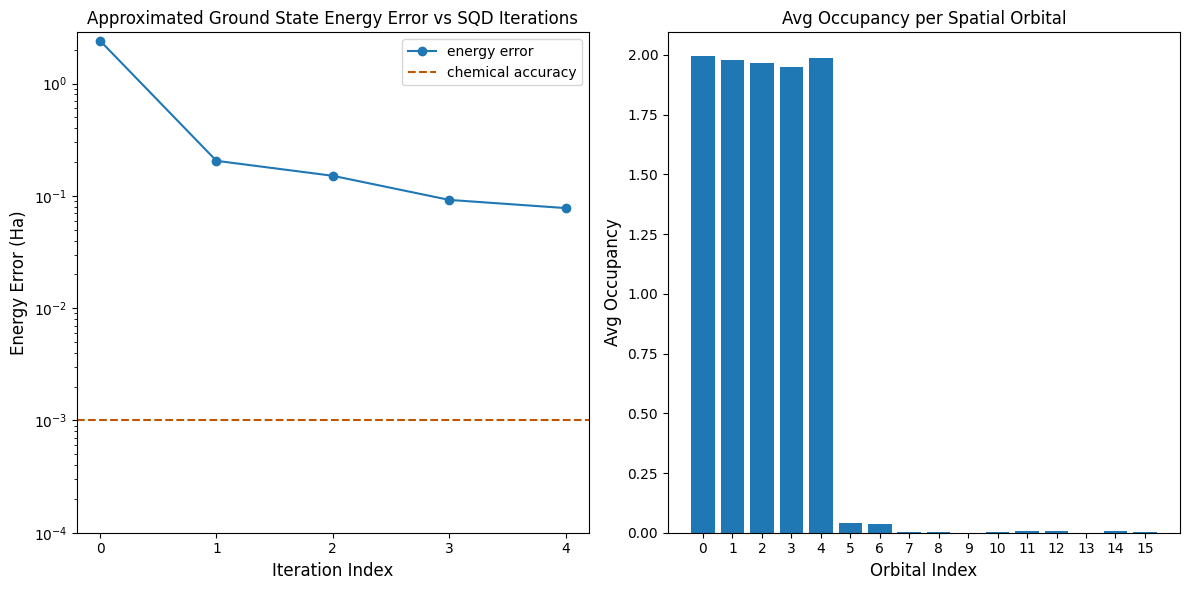

In [15]:
plot_energy_and_occupancy(result_history, exact_energy)

첫 번째 그래프에서는 몇 번의 반복을 거친 이후, 바닥상태 에너지를 약 `~100 mH` 범위 내에서 예측하는 것을 확인 할 수 있습니다. 일반적으로 화학적 정밀도는 `1 kcal/mol` $\approx$ `1.6 mH`로 정의되므로, 현재의 정확도는 이에 비하면 다소 부족합니다. 양자 회로에서 더 많은 샘플을 추출하거나, 각 배치에서 사용하는 샘플 수를 증가시킴으로써 이 에너지 추정값을 개선할 수 있습니다.

두 번째 그래프는 최종 반복 이후 각 공간 오비탈의 평균 점유율을 나타냅니다. 이 결과를 통해 스핀 업 및 스핀 다운 전자 모두가 첫 5개의 오비탈을 높은 확률로 점유하는 것을 확인할 수 있습니다.

<a id="exercise_2"></a>
<div class="alert alert-block alert-success">
    
<b>연습문제 2: 전자 배치 복원을 통한 비트 교정</b> 

STO-3G 기저 집합을 사용하여 준비된 $N_2$ 분자에 대해 전자 배치 복원을 수행한다고 가정하겠습니다. 평균 오비탈 점유도 $n$ 이 다음과 같을 때, 주어진 비트열 $x$ 를 복원 과정을 통해 교정하려고 합니다. 이 경우, 주어진 비트열은 어떤 비트열로 수정될 가능성이 높을지 결정하십시오.

$n = [0.007, 0.029, 0.029, 0.995, 
     0.976, 0.976, 0.993, 0.997, 
     0.007, 0.029, 0.029, 0.995,
     0.976, 0.976, 0.993, 0.997]$

$x = [1, 0, 0, 0,  1, 0, 1, 1,  1, 0, 1, 1,  1, 1, 0, 0]$

비트를 뒤집을 때의 가중 확률 $w(y)$은 다음의 변형된 ReLU 함수를 사용하여 계산합니다 [2].
$$
\begin{align}
    w(y) = \begin{cases} 
    \delta\cdot \frac{y}{h} & \text{if }  y \leq h\\ 
    \delta + (1 - \delta)\cdot \frac{y - h}{1 - h} & \text{if } y > h
\end{cases}
\end{align}
$$ 

여기서, $y$는 비트를 뒤집을 확률로 정의되며, $i$-번째 스핀 오비탈에 대해 $y[i] =|x[i]-n[i]|$ 로 나타낼 수 있습니다.
여기서 $h$는 ReLU 함수의 꺾임 지점("corner")을 나타내며, $\delta$는 꺾임 지점에서의 ReLU 함수의 값을 정의하는 매개변수입니다. 본 예시에서는 [2]와 동일하게 $\delta = 0.01$을 사용하고, $h$는 알파(또는 베타) 스핀 오비탈 수로 나눈 값, 즉 채움 인자(filling factor)로 정의됩니다.

실제 전자 배치 복원 과정에서는 $w(y)$를 가중치로 하여 무작위로 비트를 뒤집습니다. 본 연습문제에서는 가장 큰 $w(y[i])$ 값을 갖는 비트 $i$를 뒤집었을 때 얻어질 비트열을 최종 정답으로 하여, 얻어질 확률이 가장 높은 비트열을 답안으로 제시하십시오.

참고:
- 주어진 비트열에서 오른쪽 절반은 스핀 업 오비탈을 나타내며, 왼쪽 절반은 스핀 다운 오비탈을 나타냅니다. 여기서 `1`은 해당 오비탈이 전자에 의해 점유된 상태를 나타내고, `0`은 오비탈이 비어 있는 상태를 나타냅니다.
- 더 자세한 내용은 IBM Quantum Learning의 "Quantum Diagonalization Algorithm" 코스 중 ["4.1 Configuration recovery overview" in Lesson 4: SQD application](https://quantum.cloud.ibm.com/learning/en/courses/quantum-diagonalization-algorithms/sqd-implementation) 부분을 참조하십시오.
- 본 연습문제의 경우에는 현재 스핀-베타 전자가 1개 더 필요한 상황이므로, 만약 특정 오비탈 $i$가 이미 점유된 상태라서 뒤집을 필요가 없다면, 해당 오비탈의 y_beta[i] 값을 0으로 설정합니다.

In [26]:
n = [0.007, 0.029, 0.029, 0.995, 
     0.976, 0.976, 0.993, 0.997, 
     0.007, 0.029, 0.029, 0.995,
     0.976, 0.976, 0.993, 0.997]

x = [1, 0, 0, 0,  1, 0, 1, 1,  1, 0, 1, 1,  1, 1, 0, 0]

In [27]:
# --- 아래에 코드를 작성해주세요 ---

# 알파 스핀과 베타 스핀 나누기
n=np.array(n)
x=np.array(x)

x_alpha = x[8:]
x_beta = x[:8]

y = np.abs(x - n)
y_beta = y[:8]
y_alpha = y[8:]

# Set y_beta[i] = (1 - h) if x_beta[i] == 1
for i in range(len(y_beta)):
    if x_beta[i] == 1:
        y_beta[i] = 0

print("y_beta:", y_beta)

y_beta: [0.    0.029 0.029 0.995 0.    0.976 0.    0.   ]


In [28]:
h = 5/8
delta = 0.01


w = np.zeros(len(y_beta))
for i in range(len(y_beta)):
    if y_beta[i] <= h:
        w[i] = delta * (y_beta[i] / h)
    else:
        w[i] = delta + (1 - delta) * ((y_beta[i] - h) / (1 - h))
print(w)

[0.0000e+00 4.6400e-04 4.6400e-04 9.8680e-01 0.0000e+00 9.3664e-01
 0.0000e+00 0.0000e+00]


In [29]:
max_index = np.argmax(w)
max_w = w[max_index]

# Flip the corresponding spin down orbital
corrected_x = x.copy()
corrected_x[max_index] = 1 - corrected_x[max_index]  # Flip in spin down section
corrected_x = corrected_x.tolist()

print(corrected_x)

[1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0]


In [30]:
# 아래의 함수를 실행해 답안을 제출해주세요

grade_lab3_ex2(corrected_x) # Expected result type: list

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


# 5. 가설해 개선

양자 회로에서의 샘플링 정확도가 높을수록, SQD 알고리즘을 통해 얻는 결과 역시 향상됩니다. 따라서 샘플링을 수행하는 가설해를 어떻게 구성하는가는 SQD 성능을 좌우하는 핵심 요소 중 하나입니다. 가설해 설정에 따라 샘플링되는 비트열이 달라지며, 궁극적으로 얻을 수 있는 에너지 추정값의 정확도에 직접적인 영향을 미치게 됩니다. 이번 세션에서는 서로 다른 형태의 가설해를 탐구하여 최종 결과를 개선하는 방안에 대해 살펴보겠습니다.

## 5.1 기저 집합의 변경

먼저, 기저 집합을 변경하여 분자 시스템을 더욱 자연스럽게 모델링해 보겠습니다. 이는 더 많은 전자 오비탈을 계산에 포함하도록 합니다. 더 많은 오비탈을 계산에 포함하면 계산 복잡성이 증가하지만, 일반적으로 에너지 추정값의 정확도를 높이고 결과적으로 더 낮은 에너지 값을 얻을 수 있습니다.

<a id="exercise_3"></a>
<div class="alert alert-block alert-success">
    
<b>연습문제 3: 기저 집합 변경</b> 

분자의 기저 집합을 기존의 `6-31G` 에서 `cc-pvdz`로 변경해 보십시오. 이때 양자 하드웨어 백엔드로 `ibm_torino`를 사용하여, 6개의 보조 큐비트를 포함하는 LUCJ 가설해를 구성한다고 가정할 때, 필요한 총 큐비트 수는 얼마인지 계산하십시오.
참고: `ibm_torino` 하드웨어의 기하학적 제한으로 인해 본 예시에서는 사용할 수 있는 보조 큐비트의 최대개수가 6개로 제한되어 있습니다.

</div>

In [32]:
warnings.filterwarnings("ignore")

# 분자의 성질 특정
open_shell = False
spin_sq = 0

# N2 분자 구축
mol = pyscf.gto.Mole()
mol.build(
    atom=[["N", (0, 0, 0)], ["N", (1.0, 0, 0)]],
    # --- 아래에 코드를 작성해주세요 ---
    basis= "cc-pvdz",
    # --- 코드 작성이 완료되었습니다 ---
    symmetry="Dooh",
)

# 활성 공간 정의
n_frozen = 2
active_space = range(n_frozen, mol.nao_nr())

# 분자 적분 계산
scf = pyscf.scf.RHF(mol).run()
num_orbitals = len(active_space)
n_electrons = int(sum(scf.mo_occ[active_space]))
num_elec_a = (n_electrons + mol.spin) // 2
num_elec_b = (n_electrons - mol.spin) // 2
cas = pyscf.mcscf.CASCI(scf, num_orbitals, (num_elec_a, num_elec_b))
mo = cas.sort_mo(active_space, base=0)
hcore, nuclear_repulsion_energy = cas.get_h1cas(mo)
eri = pyscf.ao2mo.restore(1, cas.get_h2cas(mo), num_orbitals)

print(num_orbitals)

converged SCF energy = -108.929838385609
26


In [33]:
# --- 아래에 코드를 작성해주세요 ---
n_qubits = 52+6
# --- 코드 작성이 완료되었습니다 ---


In [34]:
# # 아래의 함수를 실행해 답안을 제출해주세요

grade_lab3_ex3(n_qubits) # Expected result type: integer

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


## 5.2 최적의 큐비트 배치 선택

이제 총 큐비트의 개수를 결정했으므로, 다음 단계는 실제 양자 하드웨어에서 사용할 물리적 큐비트의 배치(layout)를 결정합니다. 더 큰 기저 집합을 효과적으로 활용하기 위해, 보다 우수한 성능을 가진 Heron 장치를 사용하여 최적의 배치를 선택하도록 하겠습니다.

<a id="exercise_4"></a>
<div class="alert alert-block alert-success">
    
<b>연습문제 4: 최적의 큐비트 배치 선택</b> 

최적의 결과를 얻기 위해 초기 큐비트 배치를 어떻게 선택해야 할까요? 이를 결정하려면 각 큐비트의 오류 수치를 확인해야 합니다. 다음의 큐비트 맵에서 읽기 오류(readout error)가 0.1보다 큰 큐비트는 검은색으로 표기되어 있으며, CZ 오류가 0.1보다 큰 연결(edge)은 흰색으로 나타나 있습니다.
이 정보를 바탕으로 ISA 회로를 생성하기 위한 pass_manager의 인자인 `initial_layout`을 가장 최적의 방식으로 설정하십시오.
백엔드로는 `ibm_torino`를 사용할 것이며, 이 장치의 기하학적인 제약으로 인해 사용할 수 있는 보조 큐비트의 최대 개수는 6개로 제한됩니다.

최적의 큐비트 배치를 선택하여 더 우수한 샘플링을 얻기 위해, 다음과 같은 절차를 따르십시오:
1. 먼저, `backend_target`에서 읽기 오류가 0.1 이상인 큐비트를 찾아 `bad_readout_qubits` 리스트로 정리합니다.
2. 다음으로, CZ 게이트 오류가 0.1 이상인 연결을 찾아 `bad_czgate_edges` 리스트로 정리합니다.
3. 이 결과를 이용하여 큐비트의 연결도를 시각화하며, 이때 읽기 오류가 높은 큐비트 (`bad_readout_qubits`)는 검은색으로, CZ 오류가 높은 연결(`bad_czgate_edges`)은 흰색으로 나타내어 구분합니다.
4. 마지막으로, 오류가 가장 적은 최적의 초기 큐비트 배치(initial qubit layout)를 선택합니다.


</div>

<div class="alert alert-block alert-warning">
    
⚠️ **주의:** **이 연습문제의 일관된 채점을 위해 벡엔드 정보로 미리 제공된 pickle 파일인 `backend_target_v20.pkl` 또는 `backend_target_v21.pkl`중 하나를 불러와서 이를 `backend_target`으로 사용해주십시오**. Lab 2에서는 실제 백엔드의 정보를 얻기 위해 `backend.properties()`, `backend.target` 등을 사용했지만, 이번 실습에서는 이 방법을 사용하지 않습니다. 참고로 실제 백엔드를 호출하는 코드는 주석 처리되어 있습니다.

</div>

In [ ]:
# from qiskit_ibm_runtime import QiskitRuntimeService
# service = QiskitRuntimeService(name="qgss-2025")
# backend = service.backend('ibm_torino') 
# backend_target = backend.target

In [35]:
backend = service.backend('ibm_torino') 

In [36]:
import qiskit
print(f'Qiskit: {qiskit.__version__}')

Qiskit: 2.1.1


<div class="alert alert-block alert-warning">
    
⚠️ **주의:** Qiskit 버전 2.1.x를 사용하는 경우, 다음 셀에서 `backend_target_v21.pkl` 파일을 여십시오.
</div>

In [38]:
# Qiskit version 2.0.x 사용자
#with open("utils/backend_target_v20.pkl", "rb") as f:
# Qiskit version 2.1.x 사용자
with open("utils/backend_target_v21.pkl", "rb") as f:
    backend_target = pickle.load(f)

주의: `backend_target`으로부터 "measure"와 "cz"와 같은 명령어의 속성을 얻는 방법은 ["Get QPU information with Qiskit"의 "Instruction properties" 부분](https://quantum.cloud.ibm.com/docs/en/guides/get-qpu-information#instruction-properties)을 참조하십시오.

In [39]:
BAD_READOUT_ERROR_THRESHOLD = 0.1
BAD_CZGATE_ERROR_THRESHOLD = 0.1
backend_num_qubits = 133

# --- 아래에 코드를 작성해주세요 ---
bad_readout_qubits = []
bad_czgate_edges = []

for qubit in range(backend_num_qubits):
    try:
        readout_props=backend_target["measure"][(qubit,)]
        if readout_props.error is not None and readout_props.error>BAD_READOUT_ERROR_THRESHOLD:
            bad_readout_qubits.append(qubit)
    except:
        continue
for q1 in range(backend_num_qubits):
    for q2 in range(backend_num_qubits):
        if q1==q2:
            continue
        try:
            cz_props=backend_target["cz"][(q1,q2)]
            if cz_props.error is not None and cz_props.error>BAD_CZGATE_ERROR_THRESHOLD:
                bad_czgate_edges.append((q1,q2)) 
        except KeyError:
            continue
# --- 코드 작성이 완료되었습니다 ---
print("Bad readout qubits:", bad_readout_qubits)
print("Bad CZ gates:", bad_czgate_edges)

Bad readout qubits: [12, 53, 115, 126, 131]
Bad CZ gates: [(100, 101), (101, 100)]



<div class="alert alert-block alert-warning">
<b>주의: Graphviz 라이브러리 필요</b>

`plot_coupling_map`을 사용하려면 'Graphviz' 라이브러리가 필요합니다. 설치하려면 다음의 안내 페이지를 참조하십시오.


https://graphviz.org/download 


설치를 원치 않을 경우 다음 코드 블록을 건너뛰어도 됩니다. 해당 코드는 시각화를 위한 용도로만 사용됩니다.

</div>

In [ ]:
qubit_color = []
for i in range(backend_num_qubits):
    if i in bad_readout_qubits:
        qubit_color.append("#000000") # 검은색
    else:
        qubit_color.append("#8c00ff") # 보라색
line_color = []
for e in backend_target.build_coupling_map().get_edges():
    if e in bad_czgate_edges:
        line_color.append("#ffffff") # 흰색
    else:
        line_color.append("#888888") # 회색
plot_gate_map(backend, qubit_color=qubit_color, line_color=line_color, qubit_size=50, font_size=25, figsize=(14,14))

In [40]:
# 초기 큐비트 배치를 선택합니다
# --- 아래에 코드를 작성해주세요 ---
spin_a_layout = [0,15,19,20,21,34,40,41,42,54,61,62,63,73,82,83,84,93,103,104,105,112,124,123,122,121]
spin_b_layout = [2,3,4,16,23,24,25,35,44,45,46,55,65,66,67,74,86,87,88,94,107,108,109,113,128,127]
# --- 코드 작성이 완료되었습니다 ---
initial_layout = spin_a_layout + spin_b_layout

여기서 큐비트 배치를 확인하세요:

In [ ]:
qubit_color = []
for i in range(backend_num_qubits):
    if i in bad_readout_qubits:
        qubit_color.append("#000000") # 검은색
    elif i in initial_layout:
        qubit_color.append("#ff00dd") # 분홍색
    else:
        qubit_color.append("#8c00ff") # 보라색
line_color = []
for e in backend_target.build_coupling_map().get_edges():
    if e in bad_czgate_edges:
        line_color.append("#ffffff") # 흰색
    else:
        line_color.append("#888888") # 회색
plot_gate_map(backend, qubit_color=qubit_color, line_color=line_color, qubit_size=50, font_size=25, figsize=(14,14))

In [41]:
# 아래의 함수를 실행해 답안을 제출해주세요

grade_lab3_ex4(initial_layout) # Expected result type: lists

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


## 5.3 LUCJ 가설해에 추가적인 상호작용 도입

세션 4에서 사용한 LUCJ 가설해는 다음과 같은 형태로 표현됩니다.

$$
  \lvert \Psi \rangle = \prod_{\mu=1}^L e^{\hat{K}_\mu} e^{i \hat{J}_\mu} e^{-\hat{K}_\mu} | \Phi_0 \rangle
$$

여기서 $\lvert \Phi_0 \rangle$ 는 참조 상태로서 일반적으로 하트리-폭 상태를 사용합니다. 또한 연산자 $\hat{K}_\mu$ 와 $\hat{J}_\mu$는 다음과 같이 정의됩니다.

$$
\hat{K}_\mu = \sum_{pq, \sigma} K_{pq}^\mu \, \hat{a}^\dagger_{p \sigma} \hat{a}^{\phantom{\dagger}}_{q \sigma}
\;,\;
\hat{J}_\mu = \sum_{pq, \sigma\tau} J_{pq,\sigma\tau}^\mu \, \hat{n}_{p \sigma} \hat{n}_{q \tau}
\;,
$$

여기서 $\hat{n}_{p \sigma}$ 는 다음과 같이 정의된 입자 수 연산자 입니다.

$$
\hat{n}_{p \sigma} = \hat{a}^\dagger_{p \sigma} \hat{a}^{\phantom{\dagger}}_{p \sigma}
$$

IBM의 하드웨어는 중 육각 격자의 큐비트 위상구조를 가지며, 이에 따라 $\mathbf{J}$ 행렬에 대한 인덱스 제약 조건은 다음과 같이 주어집니다.

$$
\begin{align*}
\mathbf{J}^{\alpha\alpha} &: \{(p, p+1) \; , \; p = 0, \ldots, N-2\} \\
\mathbf{J}^{\alpha\beta} &: \{(p, p) \;, \; p = 0, 4, 8, \ldots,\; p \leq N-1\}
\end{align*}
$$
여기서 $\mathbf{J}^{\alpha\alpha}= J_{p q,\alpha\alpha}^1$ 및 $\mathbf{J}^{\alpha\beta}= J_{p q,\alpha\beta}^1$로 정의됩니다.

기존의 방식에서는 $\mathbf{J}^{\alpha\alpha}$ 행렬이 같은 스핀($\alpha$ 또는 $\beta$)을 가진 인접한 오비탈 간의 상호작용만을 나타냅니다. 이번에는 자연의 물리적 상호작용을 보다 정확히 모델링하기 위해, 인접 오비탈뿐 아니라 다음으로 가까운 오비탈(next adjacent)과의 상호작용도 포함하도록 $\mathbf{J}^{\alpha\alpha}$를 수정하여 다음과 같이 정의하겠습니다.


$$
\begin{align*}
\mathbf{J}^{\alpha\alpha} &: \{(p, p+1, p+2) \; , \; p = 0, \ldots, N-3\} \\
\mathbf{J}^{\alpha\beta} &: \{(p, p) \;, \; p = 0, 4, 8, \ldots,\; p \leq N-1\}
\end{align*}
$$

<a id="exercise_5"></a>
<div class="alert alert-block alert-success">
    
<b>연습문제 5: LUCJ 가설해에 추가적인 상호작용 도입</b> 

LUCJ 가설해의 코드에서 `alpha_alpha_indices`를 수정하여, $\mathbf{J}$ 행렬이 $\alpha$ 또는 $\beta$ 스핀 오비탈의 바로 인접한 스핀뿐만 아니라, 두 단계 떨어져 있는 스핀과도 상호작용을 하도록 설정하십시오. 수정한 후, 최종적으로 완성된 `alpha_alpha_indices` 리스트를 제출하십시오.
</div>

In [ ]:
# 가설해의 초기 매개변수로 사용할 CCSD의 t1, t2 진폭을 계산
ccsd = pyscf.cc.CCSD(scf, frozen=[i for i in range(mol.nao_nr()) if i not in active_space]).run()
t1 = ccsd.t1
t2 = ccsd.t2

n_reps = 1
# --- 아래에 코드를 작성해주세요 ---
alpha_alpha_indices = [(p, p+1) for p in range(num_orbitals - 1)] + \
                      [(p, p+2) for p in range(num_orbitals - 2)]
# --- 코드 작성이 완료되었습니다 ---
alpha_beta_indices = [(p, p) for p in range(0, num_orbitals, 4)]

ucj_op = ffsim.UCJOpSpinBalanced.from_t_amplitudes(
    t2=t2,
    t1=t1,
    n_reps=n_reps,
    interaction_pairs=(alpha_alpha_indices, alpha_beta_indices),
)

nelec = (num_elec_a, num_elec_b)

# 빈 양자회로 생성
qubits = QuantumRegister(2 * num_orbitals, name="q")
circuit = QuantumCircuit(qubits)

# 하트리-폭 상태 상태를 준비하여 양자회로에 추가
circuit.append(ffsim.qiskit.PrepareHartreeFockJW(num_orbitals, nelec), qubits)

# UCJ 연산자 적용
circuit.append(ffsim.qiskit.UCJOpSpinBalancedJW(ucj_op), qubits)
circuit.measure_all()
circuit.decompose().decompose().draw("mpl", fold=-1)

E(CCSD) = -109.2177884185544  E_corr = -0.2879500329450049


In [52]:
## 아래의 함수를 실행해 답안을 제출해주세요

grade_lab3_ex5(alpha_alpha_indices) # Expected result type: list[tuple[int, int]]

Submitting your answer. Please wait...
Oops 😕! Sorry, your answer is incorrect. Please try again.
Please review your answer and try again.


축하합니다! 이번 랩도 성공적으로 완료하셨군요. 다음 세션은 보너스 세션으로 점수에는 반영되지 않습니다.

In [50]:
# 아래의 함수를 실행해 현재의 진도 상황을 확인해보세요
from qc_grader.grader.grade import check_lab_completion_status

check_lab_completion_status("qgss_2025")

Lab 0: 2/2 exercises completed (100%)
    ✅ 2260 participants have completed this lab
Lab 1: 9/9 exercises completed (100%)
    ✅ 1719 participants have completed this lab
Lab 2: 7/7 exercises completed (100%)
    ✅ 993 participants have completed this lab
Lab 3: 4/5 exercises completed (80%)
    ✅ 748 participants have completed this lab
Lab 4: 0/6 exercises completed (0%)
    ✅ 535 participants have completed this lab
Functions Labs: 0/8 exercises completed (0%)
    ✅ 3 participants have completed this lab


# 보너스: 실제 하드웨어에서 실행 및 오류 완화

마지막으로, 수정된 가설해 회로를 실제 양자 하드웨어에서 실행한 후, 전자 배치 복원 루프를 통해 최종적으로 에너지를 계산해 봅시다. 이 과정에서, 양자 하드웨어 실행 시 발생할 수 있는 오류의 영향을 최대한 줄이기 위해 오류 완화 기법을 함께 사용할 것입니다.

In [ ]:
service = QiskitRuntimeService(name="qgss-2025")
backend = service.backend('ibm_torino')

In [ ]:
pass_manager = generate_preset_pass_manager(
    optimization_level=3, backend=backend, initial_layout=initial_layout
)

# 이 패스 매니저에 의해 생성된 회로를 하드웨어 실행에 사용할 것입니다.
pass_manager.pre_init = ffsim.qiskit.PRE_INIT
isa_circuit = pass_manager.run(circuit)
print(f"Gate counts (w/ pre-init passes): {isa_circuit.count_ops()}")

In [ ]:
opts = SamplerOptions()
opts.dynamical_decoupling.enable = True
opts.twirling.enable_measure = True

sampler = Sampler(mode=backend, options=opts)
job = sampler.run([isa_circuit], shots=100_000)
print("job id:", job.job_id())
job.status()

In [ ]:
service = QiskitRuntimeService(name="qgss-2025")

# 위의 셀에서 job id를 가져오세요
job = service.job('job_id를_입력하세요')

In [ ]:
job.status()

<div class="alert alert-block alert-warning">
<b>주의: 약 20분의 실행 시간 소요</b>

아래의 코드를 실행하면 사용 중인 컴퓨터의 성능에 따라 20분 정도의 시간이 걸릴 수 있으며, 실행이 완료될 때까지 이 노트북에서 다른 작업을 수행할 수 없습니다.

</div>

In [ ]:
%%time
primitive_result = job.result()
pub_result = primitive_result[0]
bit_array = pub_result.data.meas

# SQD 옵션 설정
energy_tol = 1e-3 
occupancies_tol = 1e-3 
max_iterations = 3

# 고유상태 계산기 옵션
num_batches = 3
samples_per_batch = 200
symmetrize_spin = True 
carryover_threshold = 1e-4 
max_cycle = 200

# 고유상태 계산기에 전달할 옵션 설정
# 기본값을 그대로 사용하고 싶다면 이 부분을 생략할 수 있으며,
# 이 경우 아래 diagonalize_fermionic_hamiltonian 함수 호출에서 sci_solver 옵션을 지정하지 않아야 합니다.
sci_solver = partial(solve_sci_batch, spin_sq=0.0, max_cycle=max_cycle) ###NEW###

# 중간 결과를 저장하기 위한 리스트
result_history = [] 

def callback(results: list[SCIResult]): 
    result_history.append(results)
    iteration = len(result_history)
    print(f"Iteration {iteration}")
    for i, result in enumerate(results):
        print(f"\tSubsample {i}")
        print(f"\t\tEnergy: {result.energy + nuclear_repulsion_energy}")
        print(f"\t\tSubspace dimension: {np.prod(result.sci_state.amplitudes.shape)}")

result = diagonalize_fermionic_hamiltonian(
    hcore,
    eri,
    bit_array,
    samples_per_batch=samples_per_batch,
    norb=num_orbitals,
    nelec=nelec,
    num_batches=num_batches,
    energy_tol=energy_tol,
    occupancies_tol=occupancies_tol,
    max_iterations=max_iterations,
    sci_solver=sci_solver,
    symmetrize_spin=symmetrize_spin,
    carryover_threshold=carryover_threshold,
    callback=callback,
    seed=rng,
)

In [ ]:
exact_energy=-109.2177884189209 # CCSD 에너지
plot_energy_and_occupancy(result_history, exact_energy)

# Reference 

\[1] M. Motta et al., “Bridging physical intuition and hardware efficiency for correlated electronic states: the local unitary cluster Jastrow ansatz for electronic structure” (2023). [Chem. Sci., 2023, 14, 11213](https://pubs.rsc.org/en/content/articlehtml/2023/sc/d3sc02516k)

\[2] J. Robledo-Moreno et al., "Chemistry Beyond Exact Solutions on a Quantum-Centric Supercomputer" (2024). [arXiv:quant-ph/2405.05068](https://arxiv.org/abs/2405.05068).

# Additional information

**Created by:** Yuri Kobayashi, Kifumi Numata

**Advised by:** Yukio Kawashima, Toshinari Itoko

**Reviewed by:** Kevin Sung, Jennifer Glick

**Translated by:** Inho Choi

**Version:** 1.0

# Qiskit packages versions

In [ ]:
import qiskit
import qiskit_ibm_runtime

print(f'Qiskit: {qiskit.__version__}')
print(f'Qiskit IBM Runtime: {qiskit_ibm_runtime.__version__}')